In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
import numpy as np
import json
from matplotlib.colors import to_hex
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from collections import defaultdict
from typing import Dict

# Preprocess the main results table

In [2]:
# Load predefined colormappings
with open("dataset_colors.json", "r") as f:
    dataset_cmap = json.load(f)
with open("method_colors.json", "r") as f:
    method_cmap = json.load(f)

In [3]:
# read through the results on each dataset
base_path = "results"
output_path = 'figure_plots'
datasets = ["cHL_2_MIBI", "IMMUcan"]
#datasets = ["cHL_2_MIBI"]
results = []
for dataset in datasets:
    df = pd.read_csv(os.path.join(base_path, dataset, "final_results.csv"), sep=";")
    df["dataset"] = dataset
    results.append(df)

results = pd.concat(results, ignore_index=True)
# rename the methods to be more readable
method_rename = {
    "logistic_regression_default_StratifiedGroupKFold": "Logistic Regression",
    "most_frequent_default_StratifiedGroupKFold": "Most Frequent",
    "random_forest_default_StratifiedGroupKFold": "Random Forest",
    "stratified_default_StratifiedGroupKFold": "Stratified sampler",
    "xgboost_default_StratifiedGroupKFold": "XGBoost",
    "celllens_full": "CellLENS_Full",
    "maps": "MAPS",
    "FuseSOM_12": "FuseSOM",
    "FuseSOM_15": "FuseSOM",
    "tribus": "Tribus",
    "scyan": "Scyan",
    "tacit": "Tacit",
    "astir": "Astir",
    "deepcelltypes": "Deepcelltypes",
    "ribca": "RIBCA",
    "ribca_adapted": "RIBCA_adapted",
    "flowsom": "FlowSOM",
    "deepcelltypes_adapted": "Deepcelltypes_adapted"
}

results["method"] = results["method"].replace(method_rename)

# Get the scalability metrics

# qc train_time_mean 
# if train_time_mean is equal to inference_time_mean, set train_time_mean to 0
results["train_time_mean"] = results["train_time_mean"].fillna(0)
results["train_time_mean"] = np.where(results["train_time_mean"] == results["inference_time_mean"], 0, results["train_time_mean"]) 
results["run_time"] = results["train_time_mean"] + results["inference_time_mean"]

# scale run_time to be between 0 and 1 with a threshold
runtime_thresh = 10800
results["runtime_scaled"] = 1 - results['run_time'] / runtime_thresh
results.loc[results['runtime_scaled'] < 0, 'runtime_scaled'] = 0

results

,method,level,f1_weighted_mean,hierarchical_f1_mean,accuracy_mean,macro_f1_mean,g_mean_mean,mcc_mean,kappa_mean,r2_mean,...,jsd_scaled_std,kl_divergence_std,kl_scaled_std,train_time_std,inference_time_std,stability,overall_score_mean,dataset,run_time,runtime_scaled
0,CellLENS_Lite,level_1,0.856754,NaN,0.871814,0.444080,0.733353,0.387539,0.375349,0.990223,...,0.020087,0.578269,0.145892,NaN,0.0,0.965411,0.699593,cHL_2_MIBI,802.312,0.925712
1,CellLENS_Lite,level_2,0.729420,NaN,0.742222,0.612457,0.544219,0.523316,0.515819,0.976513,...,0.031904,0.023723,0.021639,NaN,0.0,0.944437,0.713176,cHL_2_MIBI,802.312,0.925712
2,CellLENS_Lite,level_3,0.532263,0.714865,0.553599,0.508179,0.488963,0.483200,0.479692,0.889248,...,0.023393,0.033315,0.026143,NaN,0.0,0.904290,0.617164,cHL_2_MIBI,802.312,0.925712
3,FuseSOM,level_1,0.837625,NaN,0.848750,0.304318,0.635813,0.271765,0.260078,0.980258,...,0.000000,0.000000,0.000000,NaN,0.0,1.000000,0.655228,cHL_2_MIBI,81.816,0.992424
4,FuseSOM,level_2,0.712334,NaN,0.721433,0.510239,0.602267,0.501264,0.499749,0.987422,...,0.000000,0.000000,0.000000,NaN,0.0,1.000000,0.695431,cHL_2_MIBI,81.816,0.992424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Tribus,level_2,0.689865,NaN,0.683836,0.531833,0.266300,0.559993,0.550454,0.796052,...,0.034477,0.051491,0.041068,NaN,0.0,0.800445,0.657232,IMMUcan,163.080,0.984900
188,Tribus,level_3,0.611721,0.664520,0.576541,0.385603,0.296823,0.463314,0.455693,0.865220,...,0.031878,0.138165,0.056139,NaN,0.0,0.798031,0.620362,IMMUcan,163.080,0.984900
189,XGBoost,level_1,0.947002,NaN,0.946750,0.907800,0.912472,0.915787,0.914977,0.991828,...,0.003910,0.000678,0.000676,0.0,0.0,0.979361,0.939827,IMMUcan,6.536,0.999395
190,XGBoost,level_2,0.938819,NaN,0.938269,0.905050,0.914320,0.912231,0.911607,0.995858,...,0.003531,0.000628,0.000626,0.0,0.0,0.979888,0.938033,IMMUcan,6.536,0.999395


In [4]:
# group methods by thier methodology
method_groups = {
    "Unsupervised": ["phenograph_20", "phenograph_80","leiden_res2_0", "CellLENS_Lite","CellLENS_Full",
                         "FlowSOM", "flowsom_meta_clusters", "FuseSOM_12", "FuseSOM_15", "FuseSOM"],
    "Supervised": ["XGBoost", "Logistic Regression", "Random Forest", "MAPS", "cellsighter"],
    "Prior-Knowledge-driven": ["Tribus", "Scyan", "Tacit", "Astir"],
    "Baselines": ["Most Frequent", "Stratified sampler"],
    "Pre-trained Models": ["Deepcelltypes", "Deepcelltypes_adapted", "RIBCA", "RIBCA_adapted", "nimbus_leiden_0_8", "nimbus_phenograph_40"]  # Example, replace with actual pre-trained models
}

methods2scalability = {
    "Clustering_based" : 0.25, 
    "Supervised": 0.25,
    "Prior-knowledge based": 0.75,
    "Baselines": 1,
    "Pre-trained models": 1
}

# create scores for all methods for automation
scaling_scores = {
    "phenograph_20": 0.25,
    "phenograph_80": 0.25,
    "leiden_res2_0": 0.25,
    "CellLENS_Lite": 0.25,
    "CellLENS_Full": 0.25,
    "FlowSOM": 0.25,
    "flowsom_meta_clusters": 0.25,
    "FuseSOM_15": 0.25,
    "FuseSOM_12": 0.25,
    "FuseSOM": 0.25,
    "XGBoost": 0.25,
    "Logistic Regression": 0.25,
    "Random Forest": 0.25,
    "MAPS": 0.25,
    "Tribus": 0.6,
    "Scyan": 0.75,
    "Tacit": 0.75,
    "Astir": 0.75,
    "Most Frequent": 0,
    "Stratified sampler": 0,
    "Deepcelltypes": 1,
    "RIBCA": 1,
    "nimbus_flowsom_cluster": 0.25,
    "nimbus_leiden_0_8": 0.25,
    "nimbus_phenograph_40": 0.25,
    "cellsighter": 0.25

}

# apply scaling_scores to the results dataframe
results["scaling_score"] = results["method"].map(scaling_scores)
# scalability as a mean of the scaling_scores and the runtime_scaled
results["scalability"] = (results["scaling_score"] + results["runtime_scaled"]) / 2
metrics_for_l3 = [
    "f1_weighted_mean", "hierarchical_f1_mean", "macro_f1_mean",
    "mcc_mean", "ari_mean", "jsd_scaled_mean"
]

metrics_for_l1_l2 = [
    "f1_weighted_mean", "macro_f1_mean", "mcc_mean",
    "ari_mean", "jsd_scaled_mean"
]

mask_l3 = results['level'] == 'level_3'
mask_l1_l2 = results['level'].isin(['level_1', 'level_2'])

results.loc[mask_l3, 'weighted_score'] = results.loc[mask_l3, metrics_for_l3].mean(axis=1)
results.loc[mask_l1_l2, 'weighted_score'] = results.loc[mask_l1_l2, metrics_for_l1_l2].mean(axis=1)

In [5]:
# check rows where method is 'pehnograph_' or 'leiden_' and 
phenograph_rows = results[results["method"].str.startswith("phenograph_")]
leiden_rows = results[results["method"].str.startswith("leiden_")]
nimbus_rows = results[results["method"].str.startswith("nimbus_")]

# take the row with the highest value for overall score
phenograph_best = phenograph_rows.loc[phenograph_rows["weighted_score"].idxmax()]
leiden_best = leiden_rows.loc[leiden_rows["weighted_score"].idxmax()]
nimbus_best = nimbus_rows.loc[nimbus_rows["weighted_score"].idxmax()]

#take the name of the best phenograph and leiden methods
phenograph_best_name = phenograph_best["method"]
leiden_best_name = leiden_best["method"]
nimbus_best_name = nimbus_best["method"]

# keep only the best phenograph and leiden methods in the phenograph_rows and leiden_rows
phenograph_rows = phenograph_rows[phenograph_rows["method"] == phenograph_best_name]
leiden_rows = leiden_rows[leiden_rows["method"] == leiden_best_name]
nimbus_rows = nimbus_rows[nimbus_rows["method"] == nimbus_best_name]

#from results remove phenograph and leiden rows and add the best rows
results = results[~results["method"].str.startswith("phenograph_")]
results = results[~results["method"].str.startswith("leiden_")]
results = results[~results["method"].str.startswith("nimbus_")]
results = pd.concat([results, phenograph_rows, leiden_rows, nimbus_rows], ignore_index=True)

In [6]:
results

,method,level,f1_weighted_mean,hierarchical_f1_mean,accuracy_mean,macro_f1_mean,g_mean_mean,mcc_mean,kappa_mean,r2_mean,...,train_time_std,inference_time_std,stability,overall_score_mean,dataset,run_time,runtime_scaled,scaling_score,scalability,weighted_score
0,CellLENS_Lite,level_1,0.856754,NaN,0.871814,0.444080,0.733353,0.387539,0.375349,0.990223,...,NaN,0.0,0.965411,0.699593,cHL_2_MIBI,802.312,0.925712,0.25,0.587856,0.574676
1,CellLENS_Lite,level_2,0.729420,NaN,0.742222,0.612457,0.544219,0.523316,0.515819,0.976513,...,NaN,0.0,0.944437,0.713176,cHL_2_MIBI,802.312,0.925712,0.25,0.587856,0.628982
2,CellLENS_Lite,level_3,0.532263,0.714865,0.553599,0.508179,0.488963,0.483200,0.479692,0.889248,...,NaN,0.0,0.904290,0.617164,cHL_2_MIBI,802.312,0.925712,0.25,0.587856,0.550165
3,FuseSOM,level_1,0.837625,NaN,0.848750,0.304318,0.635813,0.271765,0.260078,0.980258,...,NaN,0.0,1.000000,0.655228,cHL_2_MIBI,81.816,0.992424,0.25,0.621212,0.502937
4,FuseSOM,level_2,0.712334,NaN,0.721433,0.510239,0.602267,0.501264,0.499749,0.987422,...,NaN,0.0,1.000000,0.695431,cHL_2_MIBI,81.816,0.992424,0.25,0.621212,0.583879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,nimbus_phenograph_40,level_2,0.675119,NaN,0.687038,0.469802,0.378544,0.423068,0.419180,0.984340,...,NaN,0.0,0.944500,0.654226,cHL_2_MIBI,335.912,0.968897,0.25,0.609449,0.547556
134,nimbus_phenograph_40,level_3,0.454613,0.654543,0.474303,0.361780,0.381191,0.386926,0.383369,0.906111,...,NaN,0.0,0.945550,0.561234,cHL_2_MIBI,335.912,0.968897,0.25,0.609449,0.469838
135,nimbus_phenograph_40,level_1,0.682415,NaN,0.692468,0.475787,0.251481,0.508202,0.503248,0.920242,...,NaN,0.0,0.960926,0.672209,IMMUcan,979.498,0.909306,0.25,0.579653,0.570062
136,nimbus_phenograph_40,level_2,0.623969,NaN,0.636553,0.442786,0.250606,0.468425,0.464113,0.930307,...,NaN,0.0,0.981908,0.653982,IMMUcan,979.498,0.909306,0.25,0.579653,0.548107


In [7]:
# ## re-calculate weighted overall score

# # Metric categories and their sub-metrics with weights
# metrics_wt = {
#     "Classification Performance": {
#         "f1_weighted_mean": 0.09,
#         "hierarcheal_f1_mean": 0.15,
#         "macro_f1_mean": 0.15,
#         "mcc_mean": 0.15,
#         "g_mean_mean": 0.06
#     },
#     "Cell Type Composition": {
#         "r2_mean": 0.04,
#         "ari_mean": 0.08,
#         "jsd_scaled_mean": 0.08
#     },
#     "Stability": {
#         "stability": 0.1
#     },
#     "Scalability": {
#         "scalability": 0.1
#     }
# }

# # calculate the weighted score for each method, only if the metric is present in final_results
# def calculate_weighted_score(row, metrics_wt):
#     score = 0
#     for category, metrics in metrics_wt.items():
#         for metric, weight in metrics.items():
#             if metric in row:
#                 score += row[metric] * weight
#     return score

# # Apply the weighted score calculation
# results['weighted_score'] = results.apply(lambda row: calculate_weighted_score(row, metrics_wt), axis=1)

In [8]:
metrics2 = [
    "method", "dataset", "level", 
    "f1_weighted_mean", "hierarchical_f1_mean", "macro_f1_mean", "mcc_mean", "ari_mean", "jsd_scaled_mean", "weighted_score",
    "stability", "scalability"
]

results2 = results[metrics2].copy()

results2.to_csv("results_table.csv", index=False, sep=";")

# Plotting

## Correlation metric plots

In [9]:
# # get a correlation matrix of the metrics
# metrics = [m for m in results.columns if m.endswith("_mean") and not m.endswith("_std")]
# metrics += ["stability", "overall_score_mean", "runtime_scaled"]
# #drop some metrics that are not needed for correlation
# metrics = [m for m in metrics if m not in ["jsd_mean", "kl_divergence_mean", "train_time_mean", "inference_time_mean"]]

# correlation_matrix = results[metrics].corr()
# plt.figure(figsize=(10, 10))
# sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="BrBG", square=True, cbar_kws={"shrink": .8})
# plt.title("Correlation Matrix of Metrics")
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

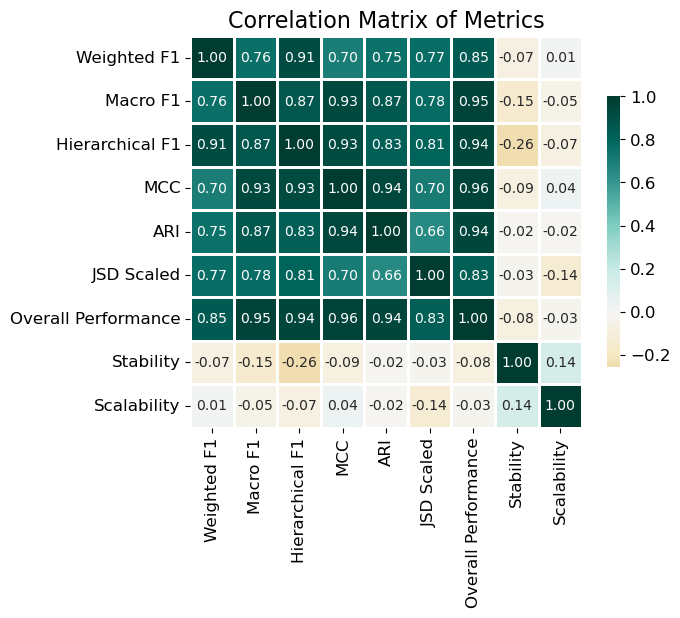

In [10]:
# pruned results to only include the relevant metrics
# get a correlation matrix of the metrics
metrics = [m for m in results.columns if m.endswith("_mean") and not m.endswith("_std")]
metrics += ["stability", "runtime_scaled"]
#drop some metrics that are not needed for correlation
metrics = ["f1_weighted_mean", 'macro_f1_mean', "hierarchical_f1_mean","mcc_mean","ari_mean", "jsd_scaled_mean",'weighted_score',
                                            "stability", "scalability"]
data = results[metrics].copy()
data = data.rename(columns={
    "f1_weighted_mean": "Weighted F1",
    "hierarchical_f1_mean": "Hierarchical F1",
    "macro_f1_mean": "Macro F1",
    "mcc_mean": "MCC",
    "ari_mean": "ARI",
    "jsd_scaled_mean": "JSD Scaled",
    "stability": "Stability",
    "scalability": "Scalability",
    "weighted_score": "Overall Performance"
})
correlation_matrix = data.corr()
plt.figure(figsize=(7, 7))
ax = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="BrBG",
    square=True,
    cbar_kws={"shrink": .5},  # removed 'center' which is not a valid argument
    annot_kws={"size": 10},
    linewidths=.75,
    center=0
)
plt.title("Correlation Matrix of Metrics", fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
# Set colorbar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "correlation_matrix_metrics.svg"), dpi=300)
plt.show()

## Heatmaps on perfromances/metrics

In [11]:
dataset = "IMMUcan"  # specify the dataset to visualize
#dataset = "cHL_2_MIBI"  # specify the dataset to visualize

df = results[results["dataset"] == dataset].set_index(["method", "level"])
df = df[metrics]
#df = df.sort_values(["overall_score", "method", "level"], ascending=[False, True, True])
df = df.sort_values(["weighted_score"], ascending=[False])

# plt.figure(figsize=(20, 20))
# sns.heatmap(df, annot=True, fmt=".2f", cmap="PuBu", cbar_kws={"shrink": .8})
# plt.title(f"Metrics for {dataset}")
# plt.xlabel("Metrics")
# plt.ylabel("Models / Level")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

In [12]:
dataset = "IMMUcan"  # specify the dataset to visualize
dataset = "cHL_2_MIBI"  # specify the dataset to visualize

df = results[(results["dataset"] == dataset) & (results["level"] == "level_3")].set_index("method")
df = df[metrics]
df = df.sort_values(["weighted_score"], ascending=[False])

# plt.figure(figsize=(12, 8))
# sns.heatmap(df, annot=True, fmt=".2f", cmap="Greens", cbar_kws={"shrink": .8})
# plt.title(f"Metrics for {dataset} (level_3 only)")
# plt.xlabel("Metrics")
# plt.ylabel("Models")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

In [13]:
dataset = "IMMUcan"  # specify the dataset to visualize
#dataset = "cHL_2_MIBI"  # specify the dataset to visualize

df = results[(results["dataset"] == dataset) & (results["level"] == "level_3")].set_index("method")
df = df[metrics]
df = df.sort_values(["weighted_score"], ascending=[False])

# plt.figure(figsize=(12, 8))
# sns.heatmap(df, annot=True, fmt=".2f", cmap="Greens", cbar_kws={"shrink": .8})
# plt.title(f"Metrics for {dataset} (level_3 only)")
# plt.xlabel("Metrics")
# plt.ylabel("Models")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()


In [14]:
# ## re-calculate weighted overall score

# # Metric categories and their sub-metrics with weights
# metrics_wt = {
#     "Classification Performance": {
#         "f1_weighted_mean": 0.09,
#         "hierarcheal_f1_mean": 0.15,
#         "macro_f1_mean": 0.15,
#         "mcc_mean": 0.15,
#         "g_mean_mean": 0.06
#     },
#     "Cell Type Composition": {
#         "r2_mean": 0.04,
#         "ari_mean": 0.08,
#         "jsd_scaled_mean": 0.08
#     },
#     "Stability": {
#         "stability": 0.1
#     },
#     "Scalability": {
#         "scalability": 0.1
#     }
# }

# # calculate the weighted score for each method, only if the metric is present in final_results
# def calculate_weighted_score(row, metrics_wt):
#     score = 0
#     for category, metrics in metrics_wt.items():
#         for metric, weight in metrics.items():
#             if metric in row:
#                 score += row[metric] * weight
#     return score

# # Apply the weighted score calculation
# results['weighted_score'] = results.apply(lambda row: calculate_weighted_score(row, metrics_wt), axis=1)

In [15]:
# Only add "scalability" and "weighted_score" if not already in metrics
for m in ["scalability", "weighted_score"]:
    if m not in metrics:
        metrics.append(m)

# Ensure metrics list is unique and preserves order
metrics = list(dict.fromkeys(metrics))

df = results[(results["dataset"] == dataset) & (results["level"] == "level_3")].set_index("method")
df = df[metrics]
# Sort by weighted_score descending, then by method name to ensure consistent order even if weighted_score is not unique
if "weighted_score" in df.columns:
    df = df.sort_values(["weighted_score", "method"], ascending=[False, True])
else:
    df = df.sort_index()

# plt.figure(figsize=(12, 8))
# sns.heatmap(df, annot=True, fmt=".2f", cmap="Greens", cbar_kws={"shrink": .8})
# plt.title(f"Metrics for {dataset} (level_3 only)")
# plt.xlabel("Metrics")
# plt.ylabel("Models")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

In [16]:
metrics = [m for m in results.columns if m.endswith("_mean") and not m.endswith("_std")]
metrics += ["stability", "scalability", "weighted_score"]
#drop some metrics that are not needed for correlation
metrics = [m for m in metrics if m not in ["jsd_mean", "kl_divergence_mean", "accuracy_mean", "kappa_mean", 
                                           "nmi_mean", "g_mean_mean","r2_mean",
                                            "pearson_corr_mean", "kl_scaled_mean", "jensen_scaled_mean",
                                            "train_time_mean", "inference_time_mean", "overall_score_mean"]]


# take mean of the metrics for each method for all datasets
df = results[results["level"] == "level_3"].groupby("method")[metrics].mean()

# Sort by weighted_score descending, then by method name to ensure consistent order even if weighted_score is not unique
df = df.sort_values(["weighted_score"], ascending=[False])

# rename the columns to be more readable
df = df.rename(columns={
    "f1_weighted_mean": "Weighted F1",
    "hierarchical_f1_mean": "Hierarchical F1",
    "macro_f1_mean": "Macro F1",
    "mcc_mean": "MCC",
    "ari_mean": "ARI",
    "jsd_scaled_mean": "JSD Scaled",
    "stability": "Stability",
    "scalability": "Scalability",
    "weighted_score": "Overall Performance"
})

# move the "Overall Performance" to before "Stability" and "Scalability"
df = df[["Weighted F1", "Hierarchical F1", "Macro F1", "MCC", "ARI", "JSD Scaled", 
         "Overall Performance",
         "Stability", "Scalability"]]


# plt.figure(figsize=(12, 8))
# sns.heatmap(df, annot=True, fmt=".2f", cmap="PuBu", cbar_kws={"shrink": .8})
# plt.title("Metrics for all datasets (level_3 only, averaged by method)")
# plt.xlabel("Metrics")
# plt.ylabel("Models")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()


In [17]:
df.to_csv("final_results_averaged.csv", sep=";")

## Minimal cell types results

In [18]:
base_path = "results"
output_path = 'figure_plots'
datasets = ["cHL_2_MIBI", "IMMUcan"]
#datasets = ["cHL_2_MIBI"]
min_results = []
for dataset in datasets:
    df = pd.read_csv(os.path.join(base_path, dataset, "minimal_results.csv"), sep=";")
    df["dataset"] = dataset
    min_results.append(df)

min_results = pd.concat(min_results, ignore_index=True)
min_results["method"] = min_results["method"].replace(method_rename)
# rename the methods to be more readable
min_results["train_time_mean"] = min_results["train_time_mean"].fillna(0)
min_results["train_time_mean"] = np.where(min_results["train_time_mean"] == min_results["inference_time_mean"], 0, min_results["train_time_mean"])
min_results["run_time"] = min_results["train_time_mean"] + min_results["inference_time_mean"]

# scale run_time to be between 0 and 1 with a threshold
runtime_thresh = 10800
min_results["runtime_scaled"] = 1 - min_results['run_time'] / runtime_thresh
min_results.loc[min_results['runtime_scaled'] < 0, 'runtime_scaled'] = 0

In [19]:
min_results[min_results['method'] == 'Most Frequent']

,method,level,f1_weighted_mean,hierarchical_f1_mean,accuracy_mean,macro_f1_mean,g_mean_mean,mcc_mean,kappa_mean,r2_mean,...,jsd_std,jsd_scaled_std,kl_divergence_std,kl_scaled_std,train_time_std,inference_time_std,stability,dataset,run_time,runtime_scaled
45,Most Frequent,level_1,1.000000,NaN,1.000000,1.000000,1.0,0.0,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,cHL_2_MIBI,0.0,1.0
46,Most Frequent,level_2,0.546825,NaN,0.651089,0.377676,1.0,0.0,0.0,1.000000,...,0.201774,0.201774,0.960543,0.199569,0.0,0.0,0.000000,cHL_2_MIBI,0.0,1.0
47,Most Frequent,level_3,0.115465,0.693456,0.263269,0.068512,1.0,0.0,0.0,0.378216,...,0.068960,0.068960,0.577579,0.055523,0.0,0.0,0.720749,cHL_2_MIBI,0.0,1.0


In [20]:
mask_l3 = min_results['level'] == 'level_3'
mask_l1_l2 = min_results['level'].isin(['level_1', 'level_2'])

min_results.loc[mask_l3, 'weighted_score'] = min_results.loc[mask_l3, metrics_for_l3].mean(axis=1)
min_results.loc[mask_l1_l2, 'weighted_score'] = min_results.loc[mask_l1_l2, metrics_for_l1_l2].mean(axis=1)

In [21]:
# apply scaling_scores to the results dataframe
min_results["scaling_score"] = min_results["method"].map(scaling_scores)
# scalability as a mean of the scaling_scores and the runtime_scaled
min_results["scalability"] = (min_results["scaling_score"] + min_results["runtime_scaled"]) / 2
# check rows where method is 'pehnograph_' or 'leiden_' and 
phenograph_rows = min_results[min_results["method"].str.startswith("phenograph_")]
leiden_rows = min_results[min_results["method"].str.startswith("leiden_")]
nimbus_rows = min_results[min_results["method"].str.startswith("nimbus_")]

# take the row with the highest value for overall score
phenograph_best = phenograph_rows.loc[phenograph_rows["weighted_score"].idxmax()]
leiden_best = leiden_rows.loc[leiden_rows["weighted_score"].idxmax()]
nimbus_best = nimbus_rows.loc[nimbus_rows["weighted_score"].idxmax()]

#take the name of the best phenograph and leiden methods
phenograph_best_name = phenograph_best["method"]
leiden_best_name = leiden_best["method"]
nimbus_best_name = nimbus_best["method"]

# keep only the best phenograph and leiden methods in the phenograph_rows and leiden_rows
phenograph_rows = phenograph_rows[phenograph_rows["method"] == phenograph_best_name]
leiden_rows = leiden_rows[leiden_rows["method"] == leiden_best_name]
nimbus_rows = nimbus_rows[nimbus_rows["method"] == nimbus_best_name]

#from results remove phenograph and leiden rows and add the best rows
min_results = min_results[~min_results["method"].str.startswith("phenograph_")]
min_results = min_results[~min_results["method"].str.startswith("leiden_")]
min_results = min_results[~min_results["method"].str.startswith("nimbus_")]
min_results = pd.concat([min_results, phenograph_rows, leiden_rows, nimbus_rows], ignore_index=True)
overall_results_min = min_results[["method", "level", "weighted_score", "dataset"]]
overall_results_min = overall_results_min[overall_results_min['level'] == 'level_3']
overall_min = overall_results_min.pivot_table(index="method", columns=["dataset", "level"], values="weighted_score")
overall_min =  overall_min.sort_values(by=list(overall_min.columns), ascending=False)
overall_min.rename(columns={"IMMUcan": "IMMUcan_min", 'cHL_2_MIBI': 'cHL_2_MIBI_min'}, inplace=True)
overall_results = results[["method", "level", "overall_score_mean", "dataset"]]
overall_results = overall_results[overall_results['level'] == 'level_3']
overall_pivot = overall_results.pivot_table(index="method", columns=["dataset", "level"], values="overall_score_mean")
overall_pivot = overall_pivot.sort_values(by=list(overall_pivot.columns), ascending=False)
merge = pd.merge(overall_pivot, overall_min, on="method", how="inner")
col_order = ['IMMUcan', 'IMMUcan_min', 'cHL_2_MIBI', 'cHL_2_MIBI_min']
merge = merge[col_order]
sorted_by_average_min = merge.loc[merge.mean(axis=1).sort_values(ascending=False).index]

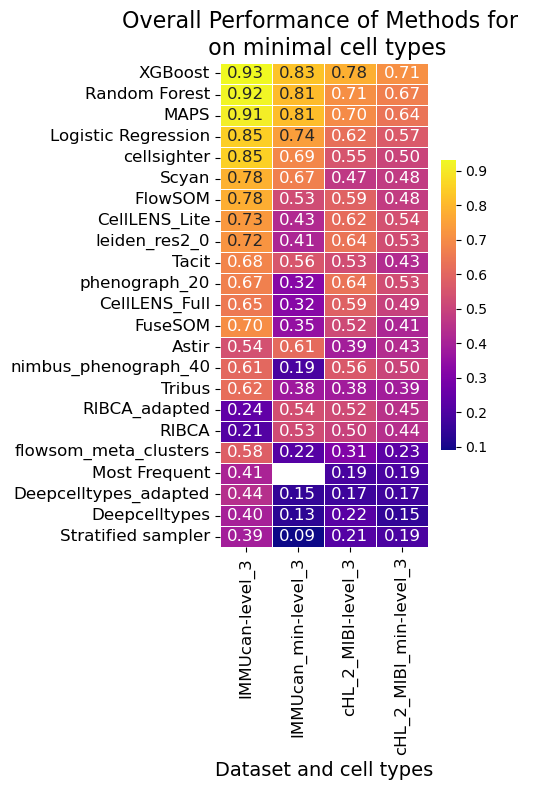

In [22]:
plt.figure(figsize=(5, 8))
sns.heatmap(sorted_by_average_min.iloc[:, :4], annot=True, fmt=".2f", cmap="plasma",
            cbar_kws={"shrink": .6}, linewidths=.6, annot_kws={"size": 12})


# Add your titles and labels
plt.title("Overall Performance of Methods for \n on minimal cell types", fontsize=16)
plt.xlabel("Dataset and cell types", fontsize=14)
plt.xticks(fontsize=12, rotation=90)
plt.ylabel("")
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "overall_performance_minimal_cell_types.svg"), dpi=300)

In [23]:
merge['IMMUcan_diff'] = merge['IMMUcan'] - merge['IMMUcan_min']
merge['cHL_2_MIBI_diff'] = merge['cHL_2_MIBI'] - merge['cHL_2_MIBI_min']

In [24]:
cols = merge.columns[-2:]
sorted_by_average_min = merge.loc[merge[cols].abs().mean(axis=1).sort_values(ascending=False).index]

In [25]:
mask = np.zeros_like(sorted_by_average_min, dtype=bool)
mask[:, :-2] = True

In [26]:
# plot a heatmap of the overall performance of each method for each level for each dataset sepaarated
# plt.figure(figsize=(6, 8))
# sns.heatmap(sorted_by_average_min, annot=True, fmt=".2f", cmap="Greys",
#             cbar=False, linewidths=.6, annot_kws={"size": 10})

# # Now, overlay the second heatmap for the specific columns.
# # We use the mask to only draw the last two columns.
# # The `plasma` colormap is applied here, and a new color bar is drawn for it.
# sns.heatmap(sorted_by_average_min, annot=True, fmt=".2f", mask=mask, cmap="plasma",
#             cbar_kws={"shrink": .6}, linewidths=.6, annot_kws={"size": 10})


# # Add your titles and labels
# plt.title("Overall Performance of Methods for \n Each Level and Dataset", fontsize=16)
# plt.xlabel("Dataset and cell type level", fontsize=14)
# plt.xticks(fontsize=12, rotation=90)
# plt.ylabel("")
# plt.yticks(fontsize=12)
# plt.tight_layout()

# # Save the figure if you want
# #plt.savefig("partially_colored_heatmap.png", dpi=300)

## Heatmaps together [dump]

In [27]:
df

,method,level,f1_weighted_mean,hierarchical_f1_mean,accuracy_mean,macro_f1_mean,g_mean_mean,mcc_mean,kappa_mean,r2_mean,...,ari_std,nmi_std,jsd_std,jsd_scaled_std,kl_divergence_std,kl_scaled_std,train_time_std,inference_time_std,stability,dataset
0,CellLENS_Lite,level_1,0.885057,NaN,0.794589,0.279965,0.794589,0.000000,0.000000,0.962805,...,0.000000,0.000000,0.036174,0.036174,1.419082,0.023166,NaN,0.0,0.869855,IMMUcan
1,CellLENS_Lite,level_2,0.821842,NaN,0.741511,0.365983,0.659987,0.494018,0.457647,0.899720,...,0.074710,0.045566,0.035251,0.035251,1.417361,0.023104,NaN,0.0,0.836499,IMMUcan
2,CellLENS_Lite,level_3,0.509160,0.713270,0.454468,0.205575,0.327034,0.381794,0.359576,0.371896,...,0.057185,0.030154,0.036901,0.036901,1.240850,0.006257,NaN,0.0,0.713174,IMMUcan
3,FuseSOM_15,level_1,0.911260,NaN,0.836986,0.303753,0.836986,0.000000,0.000000,0.981076,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,1.000000,IMMUcan
4,FuseSOM_15,level_2,0.811898,NaN,0.742566,0.383814,0.720996,0.504296,0.468142,0.960884,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0,1.000000,IMMUcan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,tribus,level_2,0.746580,NaN,0.679399,0.272534,0.645314,0.388681,0.357998,0.931693,...,0.098355,0.070468,0.049053,0.049053,2.032358,0.041495,NaN,0.0,0.707418,IMMUcan
89,tribus,level_3,0.468162,0.633519,0.374561,0.196641,0.382057,0.317555,0.298236,0.338807,...,0.038520,0.030463,0.092032,0.092032,4.871590,0.022364,NaN,0.0,0.512751,IMMUcan
90,xgboost_default_StratifiedGroupKFold,level_1,0.991504,NaN,0.983152,0.247876,0.983152,0.000000,0.000000,0.999954,...,0.000000,0.000000,0.003108,0.003108,0.033539,0.015188,0.0,0.0,0.997081,IMMUcan
91,xgboost_default_StratifiedGroupKFold,level_2,0.970816,NaN,0.962808,0.383553,0.945304,0.898970,0.898379,0.999514,...,0.007251,0.010525,0.002861,0.002861,0.033359,0.015101,0.0,0.0,0.990933,IMMUcan


In [28]:
# plot a heatmap of the results of only one dataset with metrics on the x-axis and models on the y-axis
# split by dataset
dataset1 = "IMMUcan"
dataset2 = "cHL_2_MIBI"
df = results[results["dataset"] == dataset1].set_index("method")
df = df[metrics]
df = df.sort_values(["weighted_score", "method"], ascending=[False, True])
# Create subplots
# fig, axes = plt.subplots(1, 2, figsize=(25, len(df) * 0.5), sharey=True)

# cmap = 'coolwarm'

# # Plot group 1
# sns.heatmap(df, ax=axes[0], cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=1, cbar=False)
# axes[0].set_title(dataset1)
# axes[0].set_ylabel('Methods')
# axes[0].xaxis.set_label_position('top')
# axes[0].xaxis.tick_top()

# # Plot group 2
# df = results[results["dataset"] == dataset2].set_index("method")
# df = df[metrics]
# df = df.sort_values(["weighted_score", "method"], ascending=[False, True])
# sns.heatmap(df, cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=1, cbar=False)
# axes[1].set_title(dataset2)
# axes[1].set_ylabel('')  # no need to repeat y-label
# axes[1].tick_params(axis='y', left=False)  # remove ticks on y-axis
# axes[1].xaxis.set_label_position('top')
# axes[1].xaxis.tick_top()

# #plt.xticks(rotation=90)
# plt.tight_layout()

## Heatmap with overall over all levels

In [29]:
# get the overall performance of each method for each level
overall_results = results[["method", "level", "overall_score_mean", "dataset"]]
overall_results


,method,level,overall_score_mean,dataset
0,CellLENS_Lite,level_1,0.699593,cHL_2_MIBI
1,CellLENS_Lite,level_2,0.713176,cHL_2_MIBI
2,CellLENS_Lite,level_3,0.617164,cHL_2_MIBI
3,FuseSOM,level_1,0.655228,cHL_2_MIBI
4,FuseSOM,level_2,0.695431,cHL_2_MIBI
...,...,...,...,...
133,nimbus_phenograph_40,level_2,0.654226,cHL_2_MIBI
134,nimbus_phenograph_40,level_3,0.561234,cHL_2_MIBI
135,nimbus_phenograph_40,level_1,0.672209,IMMUcan
136,nimbus_phenograph_40,level_2,0.653982,IMMUcan


In [30]:
# for each dataset, plot a heatmap of the overall performance of each method for each level
# for dataset in datasets:
#     df = overall_results[overall_results["dataset"] == dataset].pivot(index="method", columns="level", values="overall_score_mean")
#     df = df.sort_values(by=list(df.columns), ascending=False)
#     plt.figure(figsize=(14, 8))
#     # Only plot heatmap if df is not empty and has at least one column and one row
#     if not df.empty and df.shape[1] > 0 and df.shape[0] > 0:
#         sns.heatmap(df, annot=True, fmt=".2f", cmap="PuBu", cbar_kws={"shrink": .8})
#     else:
#         print(f"Warning: No data to plot for dataset '{dataset}'")
#     plt.title(f"Overall Performance for {dataset} (Methods vs Levels)")
#     plt.xlabel("Level")
#     plt.ylabel("Method")
#     plt.xticks(rotation=0)
#     plt.tight_layout()
#     plt.show()


In [31]:
# pivot table for overall performance of each method for each level
overall_pivot = overall_results.pivot_table(index="method", columns=["dataset", "level"], values="overall_score_mean")
overall_pivot = overall_pivot.sort_values(by=list(overall_pivot.columns), ascending=False
)
overall_pivot

dataset                 IMMUcan                     cHL_2_MIBI            \
level                   level_1   level_2   level_3    level_1   level_2   
method                                                                     
XGBoost                0.939827  0.938033  0.932366   0.768250  0.846488   
Random Forest          0.934778  0.931461  0.922749   0.746068  0.811831   
MAPS                   0.921727  0.919903  0.911824   0.823345  0.794851   
cellsighter            0.877688  0.871437  0.850272   0.640718  0.667998   
Logistic Regression    0.862456  0.857429  0.847260   0.684438  0.724138   
FlowSOM                0.840191  0.829645  0.778982   0.659957  0.718152   
Scyan                  0.809312  0.801072  0.784375   0.638582  0.651301   
FuseSOM                0.803562  0.778476  0.702208   0.655228  0.695431   
CellLENS_Lite          0.782111  0.780483  0.729602   0.699593  0.713176   
leiden_res2_0          0.774675  0.769655  0.718751   0.708909  0.746443   
flowsom_meta_clusters  0.737984  0.628797  0.579184   0.547110  0.458097   
CellLENS_Full          0.732870  0.716619  0.651890   0.680509  0.677911   
phenograph_20          0.728039  0.728259  0.671559   0.710310  0.745308   
Tacit                  0.727119  0.684942  0.680648   0.680262  0.672070   
Tribus                 0.702199  0.657232  0.620362   0.570439  0.455622   
nimbus_phenograph_40   0.672209  0.653982  0.605001   0.632581  0.654226   
Deepcelltypes_adapted  0.571355  0.476622  0.439995   0.481028  0.424457   
Astir                  0.523444  0.494543  0.538846   0.503258  0.510446   
Deepcelltypes          0.501895  0.435250  0.398897   0.446262  0.407464   
Stratified sampler     0.441228  0.419795  0.392915   0.518126  0.389908   
Most Frequent          0.335737  0.389668  0.406557   0.528643  0.281618   
RIBCA                  0.257686  0.220725  0.211999   0.598491  0.662652   
RIBCA_adapted          0.236011  0.247206  0.238927   0.628400  0.706974   

dataset                          
level                   level_3  
method                           
XGBoost                0.784181  
Random Forest          0.708233  
MAPS                   0.697146  
cellsighter            0.551612  
Logistic Regression    0.623528  
FlowSOM                0.590148  
Scyan                  0.470519  
FuseSOM                0.520754  
CellLENS_Lite          0.617164  
leiden_res2_0          0.639071  
flowsom_meta_clusters  0.310191  
CellLENS_Full          0.585207  
phenograph_20          0.637763  
Tacit                  0.530316  
Tribus                 0.384008  
nimbus_phenograph_40   0.561234  
Deepcelltypes_adapted  0.166586  
Astir                  0.392579  
Deepcelltypes          0.221727  
Stratified sampler     0.214936  
Most Frequent          0.187708  
RIBCA                  0.496801  
RIBCA_adapted          0.521552

In [32]:
sorted_by_average = overall_pivot.loc[overall_pivot.mean(axis=1).sort_values(ascending=False).index]
sorted_by_average

dataset                 IMMUcan                     cHL_2_MIBI            \
level                   level_1   level_2   level_3    level_1   level_2   
method                                                                     
XGBoost                0.939827  0.938033  0.932366   0.768250  0.846488   
MAPS                   0.921727  0.919903  0.911824   0.823345  0.794851   
Random Forest          0.934778  0.931461  0.922749   0.746068  0.811831   
Logistic Regression    0.862456  0.857429  0.847260   0.684438  0.724138   
cellsighter            0.877688  0.871437  0.850272   0.640718  0.667998   
FlowSOM                0.840191  0.829645  0.778982   0.659957  0.718152   
leiden_res2_0          0.774675  0.769655  0.718751   0.708909  0.746443   
CellLENS_Lite          0.782111  0.780483  0.729602   0.699593  0.713176   
phenograph_20          0.728039  0.728259  0.671559   0.710310  0.745308   
FuseSOM                0.803562  0.778476  0.702208   0.655228  0.695431   
Scyan                  0.809312  0.801072  0.784375   0.638582  0.651301   
CellLENS_Full          0.732870  0.716619  0.651890   0.680509  0.677911   
Tacit                  0.727119  0.684942  0.680648   0.680262  0.672070   
nimbus_phenograph_40   0.672209  0.653982  0.605001   0.632581  0.654226   
Tribus                 0.702199  0.657232  0.620362   0.570439  0.455622   
flowsom_meta_clusters  0.737984  0.628797  0.579184   0.547110  0.458097   
Astir                  0.523444  0.494543  0.538846   0.503258  0.510446   
RIBCA_adapted          0.236011  0.247206  0.238927   0.628400  0.706974   
Deepcelltypes_adapted  0.571355  0.476622  0.439995   0.481028  0.424457   
RIBCA                  0.257686  0.220725  0.211999   0.598491  0.662652   
Deepcelltypes          0.501895  0.435250  0.398897   0.446262  0.407464   
Stratified sampler     0.441228  0.419795  0.392915   0.518126  0.389908   
Most Frequent          0.335737  0.389668  0.406557   0.528643  0.281618   

dataset                          
level                   level_3  
method                           
XGBoost                0.784181  
MAPS                   0.697146  
Random Forest          0.708233  
Logistic Regression    0.623528  
cellsighter            0.551612  
FlowSOM                0.590148  
leiden_res2_0          0.639071  
CellLENS_Lite          0.617164  
phenograph_20          0.637763  
FuseSOM                0.520754  
Scyan                  0.470519  
CellLENS_Full          0.585207  
Tacit                  0.530316  
nimbus_phenograph_40   0.561234  
Tribus                 0.384008  
flowsom_meta_clusters  0.310191  
Astir                  0.392579  
RIBCA_adapted          0.521552  
Deepcelltypes_adapted  0.166586  
RIBCA                  0.496801  
Deepcelltypes          0.221727  
Stratified sampler     0.214936  
Most Frequent          0.187708

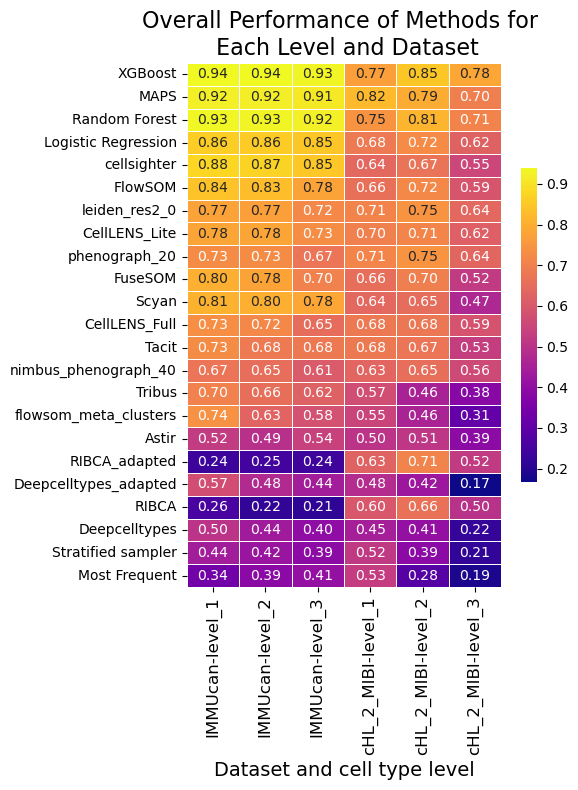

In [33]:
# plot a heatmap of the overall performance of each method for each level for each dataset sepaarated
plt.figure(figsize=(6, 8))
sns.heatmap(sorted_by_average, annot=True, fmt=".2f", cmap="plasma", cbar_kws={"shrink": .6}, annot_kws={"size": 10}, linewidths=.6)
plt.title("Overall Performance of Methods for \n Each Level and Dataset", fontsize=16)
plt.xlabel("Dataset and cell type level", fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel("")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "overall_performance_heatmap_granularities.svg"), dpi=300)
plt.show()

## Overall performances over all methods and datasets

In [34]:
overall_performance = results.groupby("method")["weighted_score"].mean().sort_values(ascending=False).reset_index()
overall_performance

,method,weighted_score
0,XGBoost,0.841638
1,MAPS,0.826687
2,Random Forest,0.814122
3,Logistic Regression,0.730008
4,cellsighter,0.693491
5,FlowSOM,0.655014
6,leiden_res2_0,0.636992
7,CellLENS_Lite,0.633961
8,Scyan,0.626469
9,phenograph_20,0.609227


In [35]:
method_groups

{'Unsupervised': ['phenograph_20',
  'phenograph_80',
  'leiden_res2_0',
  'CellLENS_Lite',
  'CellLENS_Full',
  'FlowSOM',
  'flowsom_meta_clusters',
  'FuseSOM_12',
  'FuseSOM_15',
  'FuseSOM'],
 'Supervised': ['XGBoost',
  'Logistic Regression',
  'Random Forest',
  'MAPS',
  'cellsighter'],
 'Prior-Knowledge-driven': ['Tribus', 'Scyan', 'Tacit', 'Astir'],
 'Baselines': ['Most Frequent', 'Stratified sampler'],
 'Pre-trained Models': ['Deepcelltypes',
  'Deepcelltypes_adapted',
  'RIBCA',
  'RIBCA_adapted',
  'nimbus_leiden_0_8',
  'nimbus_phenograph_40']}

In [36]:
# Prepare method group mapping for each method
method_to_group = {}
for group, methods in method_groups.items():
    for m in methods:
        method_to_group[m] = group

# Use readable names from method_rename
method_to_group.update({method_rename.get(k, k): v for k, v in method_to_group.items()})

# Create a DataFrame for plotting
plot_df = overall_performance.reset_index()
plot_df["group"] = plot_df["method"].map(method_to_group).fillna("Other")

# Sort by group, then by score
plot_df = plot_df.sort_values(["group", "weighted_score"], ascending=[True, False])

# # Add horizontal dotted lines for baselines
# baseline_scores = plot_df[plot_df["group"] == "baselines"]["overall_score"]
# for score in baseline_scores:
#     plt.axhline(y=score, color='gray', linestyle='--', linewidth=0.8)

    
# plt.figure(figsize=(14, 7))
# sns.barplot(x="method", y="overall_score", hue="group", data=plot_df, dodge=False, palette="gist_earth")
# plt.title("Overall Performance of Each Method Across All Datasets (Grouped)")
# plt.xlabel("Method")
# plt.ylabel("Overall Score")
# plt.xticks(rotation=45, ha='right')
# plt.legend(title="Method Group", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

In [37]:
plot_df

,index,method,weighted_score,group
20,20,Stratified sampler,0.276581,Baselines
22,22,Most Frequent,0.200469,Baselines
14,14,nimbus_phenograph_40,0.517661,Pre-trained Models
17,17,RIBCA_adapted,0.378613,Pre-trained Models
18,18,RIBCA,0.337018,Pre-trained Models
19,19,Deepcelltypes_adapted,0.304719,Pre-trained Models
21,21,Deepcelltypes,0.238132,Pre-trained Models
8,8,Scyan,0.626469,Prior-Knowledge-driven
10,10,Tacit,0.591974,Prior-Knowledge-driven
13,13,Tribus,0.527481,Prior-Knowledge-driven


In [38]:
# # Compute mean overall_score per group
# group_order = plot_df.groupby("group")["weighted_score"].mean().sort_values(ascending=True).index.tolist()

# plt.figure(figsize=(14, 7))
# ax = sns.barplot(
#     x="method",
#     y="weighted_score",
#     hue="group",
#     data=plot_df,
#     dodge=False,
#     palette=method_cmap,
#     hue_order=group_order
# )

# # Add horizontal dotted lines for baselines
# baseline_scores = plot_df[plot_df["group"] == "baselines"]["weighted_score"]
# for score in baseline_scores:
#     plt.axhline(score, color="gray", linestyle=":", linewidth=2, alpha=0.7)

# plt.title("Overall Performance of Each Method Across All Datasets (Grouped)")
# plt.xlabel("Methods")
# plt.ylabel("Overall Score")
# plt.xticks(rotation=45, ha='right')
# plt.legend(title="Method Group", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()


## Overall scores

In [39]:
results

,method,level,f1_weighted_mean,hierarchical_f1_mean,accuracy_mean,macro_f1_mean,g_mean_mean,mcc_mean,kappa_mean,r2_mean,...,train_time_std,inference_time_std,stability,overall_score_mean,dataset,run_time,runtime_scaled,scaling_score,scalability,weighted_score
0,CellLENS_Lite,level_1,0.856754,NaN,0.871814,0.444080,0.733353,0.387539,0.375349,0.990223,...,NaN,0.0,0.965411,0.699593,cHL_2_MIBI,802.312,0.925712,0.25,0.587856,0.574676
1,CellLENS_Lite,level_2,0.729420,NaN,0.742222,0.612457,0.544219,0.523316,0.515819,0.976513,...,NaN,0.0,0.944437,0.713176,cHL_2_MIBI,802.312,0.925712,0.25,0.587856,0.628982
2,CellLENS_Lite,level_3,0.532263,0.714865,0.553599,0.508179,0.488963,0.483200,0.479692,0.889248,...,NaN,0.0,0.904290,0.617164,cHL_2_MIBI,802.312,0.925712,0.25,0.587856,0.550165
3,FuseSOM,level_1,0.837625,NaN,0.848750,0.304318,0.635813,0.271765,0.260078,0.980258,...,NaN,0.0,1.000000,0.655228,cHL_2_MIBI,81.816,0.992424,0.25,0.621212,0.502937
4,FuseSOM,level_2,0.712334,NaN,0.721433,0.510239,0.602267,0.501264,0.499749,0.987422,...,NaN,0.0,1.000000,0.695431,cHL_2_MIBI,81.816,0.992424,0.25,0.621212,0.583879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,nimbus_phenograph_40,level_2,0.675119,NaN,0.687038,0.469802,0.378544,0.423068,0.419180,0.984340,...,NaN,0.0,0.944500,0.654226,cHL_2_MIBI,335.912,0.968897,0.25,0.609449,0.547556
134,nimbus_phenograph_40,level_3,0.454613,0.654543,0.474303,0.361780,0.381191,0.386926,0.383369,0.906111,...,NaN,0.0,0.945550,0.561234,cHL_2_MIBI,335.912,0.968897,0.25,0.609449,0.469838
135,nimbus_phenograph_40,level_1,0.682415,NaN,0.692468,0.475787,0.251481,0.508202,0.503248,0.920242,...,NaN,0.0,0.960926,0.672209,IMMUcan,979.498,0.909306,0.25,0.579653,0.570062
136,nimbus_phenograph_40,level_2,0.623969,NaN,0.636553,0.442786,0.250606,0.468425,0.464113,0.930307,...,NaN,0.0,0.981908,0.653982,IMMUcan,979.498,0.909306,0.25,0.579653,0.548107


In [40]:
#take rows where level is level_3
results_lvl3 = results[results["level"] == "level_3"]
# pivot dataset and overall score
results2 = results_lvl3.pivot(index=["method"], columns="dataset", values=["weighted_score"])
# keep only the dataset name as the column name
results2.columns = results2.columns.droplevel(0)

results2['avg_score'] = results2.mean(axis=1)
#results2['rank'] = results2['avg_score'].rank(ascending=False, method='min')
results2

dataset,IMMUcan,cHL_2_MIBI,avg_score
method,,,
Astir,0.511870,0.400776,0.456323
CellLENS_Full,0.554334,0.506764,0.530549
CellLENS_Lite,0.653091,0.550165,0.601628
Deepcelltypes,0.235304,0.132413,0.183858
Deepcelltypes_adapted,0.302176,0.161100,0.231638
FlowSOM,0.719940,0.511097,0.615519
FuseSOM,0.605021,0.440563,0.522792
Logistic Regression,0.810906,0.638628,0.724767
MAPS,0.889596,0.715369,0.802482


In [41]:
# Step 1: Compute ranks (lower rank = better performance)
rank_df = results2.rank(ascending=False, axis=0)
# order by the avg_score   
rank_df = rank_df.sort_values(by='avg_score', ascending=True)
rank_df = rank_df[['cHL_2_MIBI', 'IMMUcan', 'avg_score']]
rank_df = results2.rank(ascending=True, axis=0)
datasets = rank_df.columns
methods = rank_df.index

# Sort methods by mean rank
rank_df = rank_df.loc[rank_df.mean(axis=1).sort_values().index]

In [42]:
rank_df

dataset,IMMUcan,cHL_2_MIBI,avg_score
method,,,
Most Frequent,1.0,1.0,1.0
Deepcelltypes,3.0,2.0,2.0
Stratified sampler,5.0,5.0,3.0
Deepcelltypes_adapted,6.0,3.0,4.0
RIBCA,2.0,7.0,5.0
flowsom_meta_clusters,7.0,4.0,6.0
RIBCA_adapted,4.0,11.0,7.0
Astir,9.0,6.0,8.0
nimbus_phenograph_40,8.0,10.0,9.0


In [43]:
def draw_curve(ax, x1, y1, x2, y2, color, linewidth=12, alpha=1):
    verts = [
        (x1, y1),                # Start point
        ((x1 + x2) / 2, y1),     # Control point 1
        ((x1 + x2) / 2, y2),     # Control point 2
        (x2, y2)                 # End point
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    path = Path(verts, codes)
    patch = PathPatch(path, facecolor='none', edgecolor=color, lw=linewidth, alpha=alpha)
    ax.add_patch(patch)

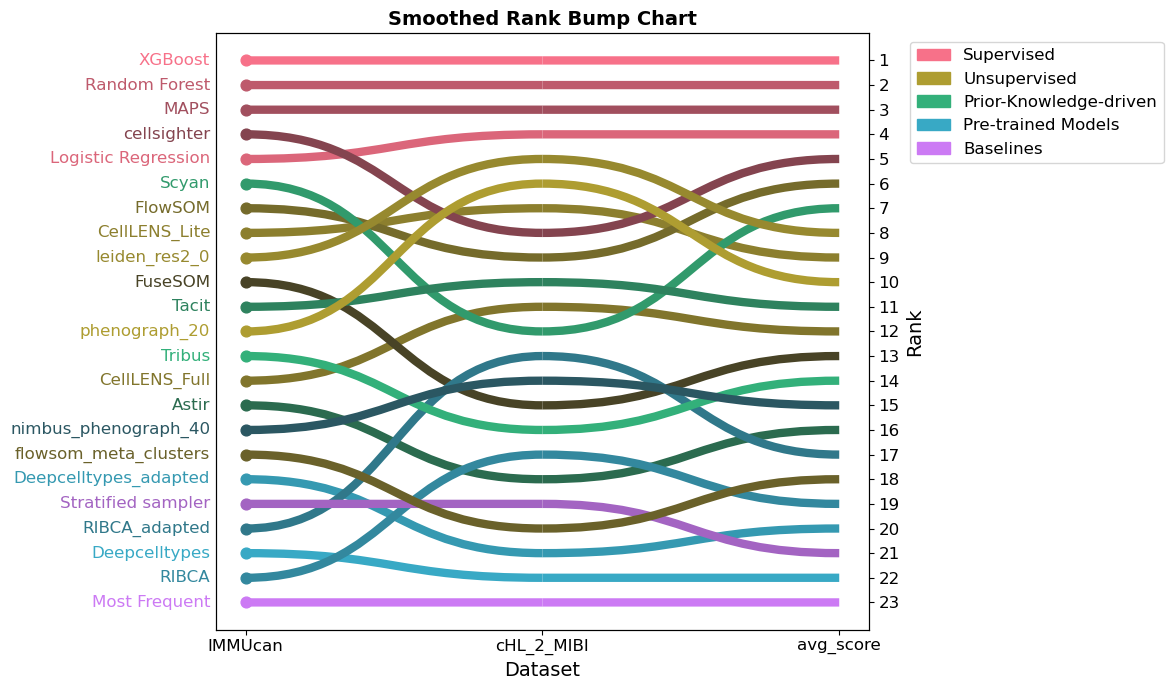

In [44]:
method_colors = {}
for group, methods_in_group in method_groups.items():
    base_color = method_cmap[group]
    
    # Create a palette starting with the base color and getting darker
    # input="rgb" ensures seaborn interprets your tuple correctly
    num_methods = len(methods_in_group)
    
    palette = sns.dark_palette(base_color, n_colors=num_methods + 3, reverse=True, input="rgb")

    for i, method in enumerate(methods_in_group):
        # Assign colors sequentially from the generated palette
        color = palette[i]
        method_colors[method] = mcolors.to_hex(color)
fig, ax = plt.subplots(figsize=(12, 7))

x_vals = np.arange(len(datasets))

for method in methods:
    y = rank_df.loc[method].values
    color = method_colors[method]

    # Draw smooth curves between each dataset
    for i in range(len(x_vals) - 1):
        draw_curve(ax, x_vals[i], y[i], x_vals[i+1], y[i+1], color=color, linewidth=6)

    # Start and end dots
    ax.scatter(x_vals[0], y[0], color=color, s=60, zorder=2)
    ax.text(x_vals[0] - 0.12, y[0], method, ha='right', va='center', color=color, fontsize=12)

# Right y-axis: rank labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(range(1, len(rank_df) + 1))
ax2.set_yticklabels(range(1, len(rank_df) + 1), fontsize=12)
ax2.set_ylabel("Rank", fontsize=14)
ax2.invert_yaxis()

# Style
ax.set_yticks([])
ax.set_ylabel("")
ax.tick_params(axis='y', left=False)
ax.set_xticks(x_vals)
ax.set_xticklabels(datasets, rotation=0, ha='center', fontsize=12)
ax.set_xlabel("Dataset", fontsize=14)
ax.set_title("Smoothed Rank Bump Chart", fontsize=14, weight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend for method groups
legend_handles = []
for group, color in method_cmap.items():
    legend_handles.append(mpatches.Patch(color=to_hex(color), label=group))
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout()
fig.savefig(os.path.join(output_path, "smoothed_rank_bump_chart.svg"), format='svg', bbox_inches='tight')
plt.show()


## Hierarcheal F1 score

In [45]:
#read the hierarchy mappings from the file
with open('hierarchy_mappings.pkl', 'rb') as f:
    import pickle
    hierarchy_mappings = pickle.load(f)

In [46]:
def build_tree(mapping: Dict[str, Dict[str, str]]) -> Dict:
    tree = defaultdict(lambda: defaultdict(list))
    for leaf, levels in mapping.items():
        level1 = levels['level_1_cell_type']
        level2 = levels['level_2_cell_type']
        tree[level1][level2].append(leaf)
    return tree

# Convert tree to indented text view
def tree_to_text(tree: Dict, indent: int = 0) -> str:
    lines = []
    for level1, sublevels in tree.items():
        lines.append('  ' * indent + level1)
        for level2, leaves in sublevels.items():
            lines.append('  ' * (indent + 1) + level2)
            for leaf in leaves:
                lines.append('  ' * (indent + 2) + leaf)
    return '\n'.join(lines)

# Create the tree and save it to a txt file
tree = build_tree(hierarchy_mappings)
tree_text = tree_to_text(tree)

# Save to a text file
file_path = "cell_type_hierarchy.txt"
with open(file_path, "w") as f:
    f.write(tree_text)

In [47]:
def parse_tree_file(file_path: str) -> dict:
    """Parses a 2-space-indented tree file and returns label -> ancestor path mapping."""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    label_to_ancestors = {}
    path_stack = []

    for line in lines:
        stripped = line.lstrip()
        indent = len(line) - len(stripped)
        level = indent // 2  # Assumes 2 spaces per indent

        path_stack = path_stack[:level]
        path_stack.append(stripped.strip())

        if level >= 2:
            label = path_stack[-1]
            label_to_ancestors[label] = path_stack[:-1]  # from root to parent

    return label_to_ancestors

In [48]:
file_path = "cell_type_hierarchy.txt"
ancestor_map = parse_tree_file(file_path)


## Dataset distributions

In [49]:
# import plotly.graph_objects as go

# def parse_tree_levels(file_path):
#     # Parse the indented tree file and return a list of (parent, child) pairs for all levels
#     with open(file_path, 'r') as f:
#         lines = f.readlines()

#     pairs = []
#     stack = []
#     for line in lines:
#         stripped = line.lstrip()
#         indent = len(line) - len(stripped)
#         level = indent // 2
#         stack = stack[:level]
#         stack.append(stripped.strip())
#         if level > 0:
#             pairs.append((stack[-2], stack[-1]))
#     return pairs

# def generate_sankey_from_tree(file_path):
#     pairs = parse_tree_levels(file_path)
#     labels = sorted(set([p for pair in pairs for p in pair]))
#     label_to_idx = {label: i for i, label in enumerate(labels)}
#     source = [label_to_idx[parent] for parent, child in pairs]
#     target = [label_to_idx[child] for parent, child in pairs]
#     value = [1] * len(pairs)

#     fig = go.Figure(data=[go.Sankey(
#         node=dict(
#             pad=15,
#             thickness=20,
#             line=dict(color="black", width=0.5),
#             label=labels,
#         ),
#         link=dict(
#             source=source,
#             target=target,
#             value=value,
#         )
#     )])
#     fig.update_layout(title_text="Cell Type Hierarchy Sankey Diagram (All Levels)", font_size=10)
#     fig.update_layout(width=1200, height=1000)
#     fig.show()

# generate_sankey_from_tree(file_path)


In [50]:
def parse_tree_for_sunburst(file_path):
    # Parse the indented tree file and return names and parents for sunburst
    names = []
    parents = []
    stack = []
    with open(file_path, 'r') as f:
        for line in f:
            stripped = line.lstrip()
            indent = len(line) - len(stripped)
            level = indent // 2
            name = stripped.strip()
            if not name:
                continue
            if level == 0:
                parent = ""
            else:
                parent = stack[level - 1]
            if name not in names:  # avoid duplicates
                names.append(name)
                parents.append(parent)
            if len(stack) <= level:
                stack.append(name)
            else:
                stack[level] = name

    return names, parents

def generate_radial_tree(file_path):
    names, parents = parse_tree_for_sunburst(file_path)
    fig = px.sunburst(
        names=names,
        parents=parents,
        width=1000,
        height=800,
        maxdepth=3,
        color_discrete_sequence=px.colors.qualitative.T10
    )

    fig.update_layout(
                        margin=dict(t=10, l=10, r=10, b=10)
                     )

    fig.show()

    fig.write_html(os.path.join(output_path, "sunburst_distribution.html"))
    fig.write_image(os.path.join(output_path, "sunburst_distribution.svg"))

generate_radial_tree(file_path)

## Metric accumulation

In [51]:
#rename id col to method
results_lvl3 = results_lvl3.rename(columns={"id": "method"})

In [52]:
# get methods and results[metrics] in a dataframe
results_cat = results_lvl3.set_index('method')
results_cat = results_cat[metrics]
# take mean of each metric by method
results_cat = results_cat.groupby(results_cat.index).mean()
results_cat

,f1_weighted_mean,hierarchical_f1_mean,macro_f1_mean,mcc_mean,ari_mean,jsd_scaled_mean,stability,scalability,weighted_score
method,,,,,,,,,
Astir,0.540685,0.534367,0.429633,0.420975,0.282387,0.529890,0.913475,0.825802,0.456323
CellLENS_Full,0.531686,0.702885,0.380603,0.467774,0.391183,0.709164,0.900091,NaN,0.530549
CellLENS_Lite,0.599530,0.745103,0.497529,0.540218,0.437566,0.789823,0.924021,0.567121,0.601628
Deepcelltypes,0.205550,0.342222,0.025556,0.066237,0.066188,0.397397,1.000000,0.781012,0.183858
Deepcelltypes_adapted,0.268449,0.393089,0.091715,0.079898,0.076427,0.480251,1.000000,NaN,0.231638
FlowSOM,0.621086,0.756877,0.469458,0.560184,0.473871,0.811635,0.966357,0.623948,0.615519
FuseSOM,0.523746,0.723114,0.334678,0.472243,0.398663,0.684309,1.000000,0.620548,0.522792
Logistic Regression,0.740831,0.805969,0.676752,0.691181,0.568661,0.865211,0.751804,0.624762,0.724767
MAPS,0.810434,0.869093,0.771846,0.777161,0.668638,0.917723,0.755027,0.587384,0.802482


/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_92548/1315850975.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



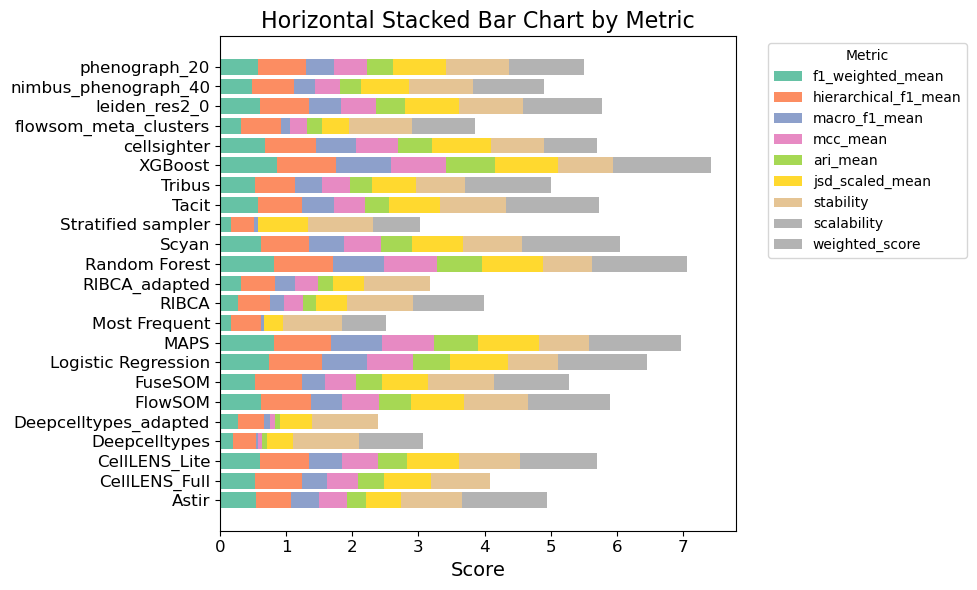

In [53]:
df = results_cat

# Check column count
n_metrics = len(df.columns)

# Choose a colormap with enough colors
from matplotlib.cm import get_cmap
cmap = get_cmap("Set2", n_metrics)  # will generate n_metrics colors
colors = [cmap(i) for i in range(n_metrics)]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
left = [0] * len(df)

# Plot each metric as a segment
for i, col in enumerate(df.columns):
    ax.barh(df.index, df[col], left=left, label=col, color=colors[i])
    left = [l + v for l, v in zip(left, df[col])]

# Aesthetics
ax.set_xlabel("Score", fontsize=14)
ax.set_title("Horizontal Stacked Bar Chart by Metric", fontsize=16)
ax.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_92548/3399861881.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



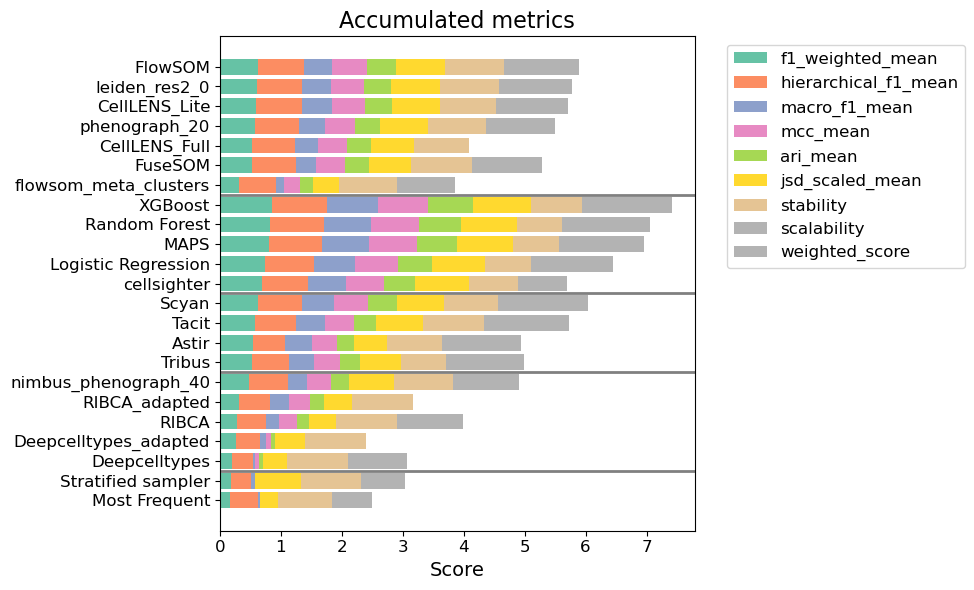

In [54]:
# Step 2: Make method → group mapping
method_to_group = {method: group for group, methods in method_groups.items() for method in methods}

# Step 3: Add group to your DataFrame
df['group'] = df.index.map(method_to_group)

# Step 4: Sort by group (and optionally by method name within group)
df_sorted = df.sort_values(by=['group', df.columns[0]])  # replace columns[0] with a metric name if needed

# Step 5: Plot horizontal stacked bar
metrics = [col for col in df_sorted.columns if col != 'group']
n_metrics = len(metrics)

# Generate distinct colors per metric
cmap = get_cmap("Set2", n_metrics)
colors = [cmap(i) for i in range(n_metrics)]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
left = [0] * len(df_sorted)

for i, col in enumerate(metrics):
    ax.barh(df_sorted.index, df_sorted[col], left=left, label=col, color=colors[i])
    left = [l + v for l, v in zip(left, df_sorted[col])]

# Get the numeric y positions of each method
y_positions = range(len(df_sorted))

# Track the last seen group
last_group = None
for i, (idx, row) in enumerate(df_sorted.iterrows()):
    current_group = row['group']
    if last_group is not None and current_group != last_group:
        # Draw a dotted line between groups
        ax.axhline(i - 0.5, color='gray', linestyle='-', linewidth=2)
    last_group = current_group

# Aesthetics
ax.set_xlabel("Score", fontsize=14)
ax.set_title("Accumulated metrics", fontsize=16)
ax.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "accumulated_metrics.svg"), dpi=300)
plt.show()

## Performance vs scalability/stability

In [55]:
df = pd.read_csv('final_results_averaged.csv', sep=';').set_index('method')
df['Method_group'] = df.index.map(method_to_group)

In [56]:
df

,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability,Method_group
method,,,,,,,,,,
XGBoost,0.856627,0.902017,0.830166,0.830505,0.732611,0.950638,0.850427,0.841642,0.624709,Supervised
Random Forest,0.818997,0.884047,0.781759,0.789616,0.678290,0.921603,0.812385,0.741491,0.623741,Supervised
MAPS,0.810434,0.869093,0.771846,0.777161,0.668638,0.917723,0.802482,0.755027,0.587384,Supervised
Logistic Regression,0.740831,0.805969,0.676752,0.691181,0.568661,0.865211,0.724767,0.751804,0.624762,Supervised
cellsighter,0.684711,0.767612,0.609490,0.622571,0.524018,0.884523,0.682154,0.799952,0.125000,Supervised
FlowSOM,0.621086,0.756877,0.469458,0.560184,0.473871,0.811635,0.615519,0.966357,0.623948,Unsupervised
Scyan,0.617996,0.734390,0.518945,0.562744,0.474503,0.764295,0.612146,0.888289,0.867727,Prior-Knowledge-driven
leiden_res2_0,0.606361,0.742242,0.475343,0.538165,0.440368,0.811239,0.602286,0.963828,0.598539,Unsupervised
CellLENS_Lite,0.599530,0.745103,0.497529,0.540218,0.437566,0.789823,0.601628,0.924021,0.567121,Unsupervised


In [57]:
fig = px.scatter(df, x="Scalability", y="Overall Performance", color=df.index,
                 size='Macro F1', hover_data=['Overall Performance', 'Scalability', 'Macro F1'])
fig.show()

In [58]:
fig = px.scatter(df, x="Scalability", y="Overall Performance", color="Method_group",
                 size='Macro F1', hover_data=[df.index,'Overall Performance', 'Scalability', 'Macro F1'],)
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
                  xaxis_title="Scalability",
                  yaxis_title="Overall Performance",
                  legend_title="Method_group")
fig.update_layout(legend=dict(title_text='Method_group', orientation='h', yanchor='bottom', y=1, xanchor='right', x=1))
fig.update_layout(template="none")
fig.show()

In [59]:
df["Scalability/Stability"] = (df["Scalability"] + df["Stability"]) / 2
fig = px.scatter(df, x="Scalability/Stability", y="Overall Performance", color="Method_group",
                 size='Macro F1', hover_data=[df.index,'Overall Performance', 'Scalability/Stability', 'Macro F1'],)

fig.update_layout(
    font=dict(
        size=12,           # Default font size for all text
    ),
    xaxis=dict(
        title_font=dict(size=14),   # X-axis title font size
        tickfont=dict(size=12),     # X-axis tick label font size
    ),
    yaxis=dict(
        title_font=dict(size=14),   # Y-axis title font size
        tickfont=dict(size=12),     # Y-axis tick label font size
    ),
    title_font=dict(size=16),       # Title font size
    legend=dict(
        font=dict(size=12),         # Legend font size
        title_font=dict(size=14),   # Legend title font size
    )
)

fig.update_layout(
    template='simple_white',
    title="Performance vs Scalability/Stability",
    xaxis=dict(title="Scalability/Stability", range=[0.6, 1]),
    #xaxis=dict(title="Scalability/Stability"),
    yaxis=dict(title="Performance Overall")
)
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))


fig.show()

fig.write_html(os.path.join(output_path, "scatter_plot_grouped.html"))

# save as svg
fig.write_image(os.path.join(output_path, "scatter_plot_grouped.svg"), width=800, height=600, scale=2)

In [60]:
# Compute combined metric
df["Scalability/Stability"] = (df["Scalability"] + df["Stability"]) / 2


In [61]:
df

,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability,Method_group,Scalability/Stability
method,,,,,,,,,,,
XGBoost,0.856627,0.902017,0.830166,0.830505,0.732611,0.950638,0.850427,0.841642,0.624709,Supervised,0.733176
Random Forest,0.818997,0.884047,0.781759,0.789616,0.678290,0.921603,0.812385,0.741491,0.623741,Supervised,0.682616
MAPS,0.810434,0.869093,0.771846,0.777161,0.668638,0.917723,0.802482,0.755027,0.587384,Supervised,0.671205
Logistic Regression,0.740831,0.805969,0.676752,0.691181,0.568661,0.865211,0.724767,0.751804,0.624762,Supervised,0.688283
cellsighter,0.684711,0.767612,0.609490,0.622571,0.524018,0.884523,0.682154,0.799952,0.125000,Supervised,0.462476
FlowSOM,0.621086,0.756877,0.469458,0.560184,0.473871,0.811635,0.615519,0.966357,0.623948,Unsupervised,0.795153
Scyan,0.617996,0.734390,0.518945,0.562744,0.474503,0.764295,0.612146,0.888289,0.867727,Prior-Knowledge-driven,0.878008
leiden_res2_0,0.606361,0.742242,0.475343,0.538165,0.440368,0.811239,0.602286,0.963828,0.598539,Unsupervised,0.781183
CellLENS_Lite,0.599530,0.745103,0.497529,0.540218,0.437566,0.789823,0.601628,0.924021,0.567121,Unsupervised,0.745571


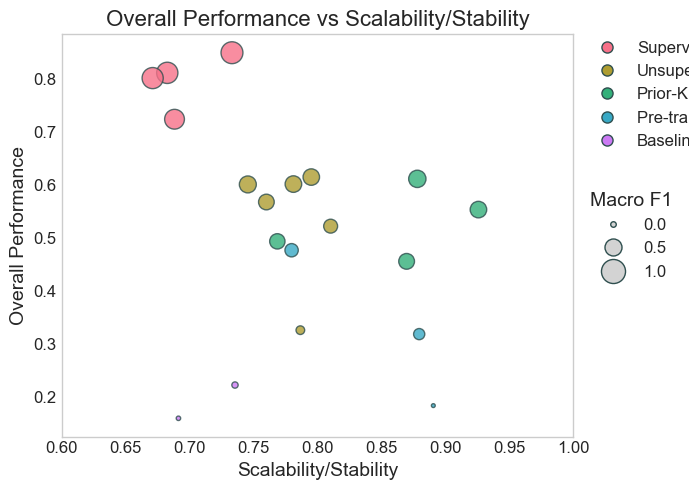

In [62]:

# Use the correct seaborn style depending on matplotlib version
methodologies = df["Method_group"].unique()
available_styles = plt.style.available
if 'seaborn-whitegrid' in available_styles:
    plt.style.use('seaborn-whitegrid')
elif 'seaborn-v0_8-whitegrid' in available_styles:
    plt.style.use('seaborn-v0_8-whitegrid')
else:
    plt.style.use('default')

fig, ax = plt.subplots(figsize=(7, 5))

# Scatter plot points
for method in methodologies:
    subset = df[df["Method_group"] == method]
    ax.scatter(
        subset["Scalability/Stability"],
        subset["Overall Performance"],
        s=subset["Macro F1"] * 300,  # scaled size
        color=method_cmap[method],
        edgecolor='darkslategrey',
        linewidth=1,
        alpha=0.8
    )

# ---------- Legend 1: Methodology colors ----------
color_handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=method,
        markerfacecolor=method_cmap[method],
        markeredgecolor='darkslategrey',
        markersize=8
    )
    for method in methodologies
]
legend1 = ax.legend(
    handles=color_handles,
    title="",
    title_fontsize=14,
    fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.02, 0.85),
    borderaxespad=0
)
legend1._legend_title_box._text.set_ha("left")  # align left
ax.add_artist(legend1)

# ---------- Legend 2: Dot size for Macro F1 ----------
# Example size values
size_values = [0, 0.5, 1]
size_handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f"{v:.1f}",
        markerfacecolor='lightgray',
        markeredgecolor='darkslategrey',
        markersize=np.sqrt(v * 300) if v > 0 else 4  # match scatter scaling
    )
    for v in size_values
]

legend2 = ax.legend(
    handles=size_handles,
    title="Macro F1",
    title_fontsize=14,
    fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0
)
legend2._legend_title_box._text.set_ha("left")  # align left

# Titles & labels
ax.set_title("Overall Performance vs Scalability/Stability", fontsize=16)
ax.set_xlabel("Scalability/Stability", fontsize=14)
ax.set_ylabel("Overall Performance", fontsize=14)
ax.set_xlim(0.6, 1)
ax.tick_params(axis='both', labelsize=12)

ax.grid(False)

plt.tight_layout()
plt.show()

# save as svg
fig.savefig(os.path.join(output_path, "performance_vs_scalability.svg"), format="svg", bbox_inches="tight")

In [63]:
df

,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability,Method_group,Scalability/Stability
method,,,,,,,,,,,
XGBoost,0.856627,0.902017,0.830166,0.830505,0.732611,0.950638,0.850427,0.841642,0.624709,Supervised,0.733176
Random Forest,0.818997,0.884047,0.781759,0.789616,0.678290,0.921603,0.812385,0.741491,0.623741,Supervised,0.682616
MAPS,0.810434,0.869093,0.771846,0.777161,0.668638,0.917723,0.802482,0.755027,0.587384,Supervised,0.671205
Logistic Regression,0.740831,0.805969,0.676752,0.691181,0.568661,0.865211,0.724767,0.751804,0.624762,Supervised,0.688283
cellsighter,0.684711,0.767612,0.609490,0.622571,0.524018,0.884523,0.682154,0.799952,0.125000,Supervised,0.462476
FlowSOM,0.621086,0.756877,0.469458,0.560184,0.473871,0.811635,0.615519,0.966357,0.623948,Unsupervised,0.795153
Scyan,0.617996,0.734390,0.518945,0.562744,0.474503,0.764295,0.612146,0.888289,0.867727,Prior-Knowledge-driven,0.878008
leiden_res2_0,0.606361,0.742242,0.475343,0.538165,0.440368,0.811239,0.602286,0.963828,0.598539,Unsupervised,0.781183
CellLENS_Lite,0.599530,0.745103,0.497529,0.540218,0.437566,0.789823,0.601628,0.924021,0.567121,Unsupervised,0.745571


## barplot

In [64]:
# take mean of the metrics for each method for all datasets
df = results[results["level"] == "level_3"]
#set methods to index
df = df.set_index("method")

# rename the columns to be more readable
df = df.rename(columns={
    "f1_weighted_mean": "Weighted F1",
    "hierarchical_f1_mean": "Hierarchical F1",
    "macro_f1_mean": "Macro F1",
    "mcc_mean": "MCC",
    "ari_mean": "ARI",
    "jsd_scaled_mean": "JSD Scaled",
    "stability": "Stability",
    "scalability": "Scalability",
    "weighted_score": "Overall Performance"
})


# Step 2: Make method → group mapping
method_to_group = {method: group for group, methods in method_groups.items() for method in methods}

df['Method_group'] = df.index.map(method_to_group)

# move the "Overall Performance" to before "Stability" and "Scalability"
df = df[["Weighted F1", "Hierarchical F1", "Macro F1", "MCC", "ARI", "JSD Scaled", 
         "Overall Performance",
         "Stability", "Scalability",
         "Method_group"]]

df

,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability,Method_group
method,,,,,,,,,,
CellLENS_Lite,0.532263,0.714865,0.508179,0.483200,0.261198,0.801281,0.550165,0.904290,0.587856,Unsupervised
FuseSOM,0.406693,0.678629,0.334189,0.363712,0.189817,0.670341,0.440563,1.000000,0.621212,Unsupervised
Astir,0.446390,0.502145,0.401245,0.347341,0.176701,0.530833,0.400776,0.922862,0.827690,Prior-Knowledge-driven
CellLENS_Full,0.490461,0.687217,0.461476,0.437024,0.215611,0.748798,0.506764,0.879579,NaN,Unsupervised
cellsighter,0.540896,0.674215,0.503694,0.471019,0.273499,0.810358,0.545613,0.636101,0.125000,Supervised
Deepcelltypes,0.105539,0.293347,0.018142,0.022256,0.009187,0.346006,0.132413,1.000000,0.859195,Pre-trained Models
Deepcelltypes_adapted,0.127358,0.320875,0.065562,0.026625,0.010777,0.415401,0.161100,1.000000,NaN,Pre-trained Models
FlowSOM,0.504021,0.699099,0.409361,0.446718,0.233960,0.773426,0.511097,0.981606,0.624231,Unsupervised
flowsom_meta_clusters,0.121728,0.555337,0.056644,0.074018,0.002628,0.294160,0.184086,0.964428,0.624231,Unsupervised


In [65]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

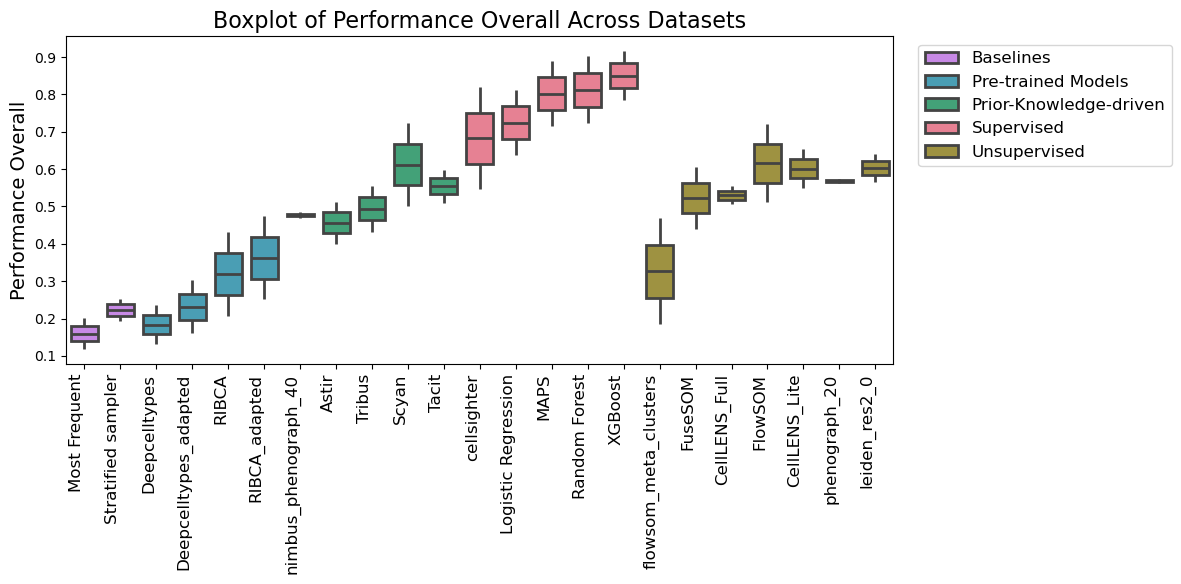

In [66]:
# Sort the dataframe by group and method
df_sorted = df.sort_values(by=["Method_group", "method"])
df_sorted = df_sorted.sort_values(by=['Method_group', 'Overall Performance'], ascending=[True, True])

# Get the order of methods after sorting (includes duplicates)
method_order = df_sorted.index.tolist()

# Use the correct seaborn style depending on matplotlib version
plt.style.use('default')

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_sorted,
    x="method",
    y="Overall Performance",
    hue="Method_group",
    palette=method_cmap,
    dodge=False,
    order=method_order,
    showcaps=False,
    linewidth=2,
    width=0.75
)

# Set font sizes
plt.rcParams.update({'font.size': 12})  # Default font size
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.xlabel('', fontsize=14)
plt.ylabel('Performance Overall', fontsize=14)
plt.title('Boxplot of Performance Overall Across Datasets', fontsize=16)

# Move legend outside the plot with custom font sizes
legend = plt.legend(title="", bbox_to_anchor=(1.02, 1), loc='upper left')
legend.get_title().set_fontsize(14)
for text in legend.get_texts():
    text.set_fontsize(12)

plt.tight_layout()

# save as svg
plt.savefig(os.path.join(output_path, "boxplot_performance_overall.svg"), format='svg', bbox_inches='tight', dpi=300)

plt.show()

## Pareto 

In [67]:
df

,Weighted F1,Hierarchical F1,Macro F1,MCC,ARI,JSD Scaled,Overall Performance,Stability,Scalability,Method_group
method,,,,,,,,,,
CellLENS_Lite,0.532263,0.714865,0.508179,0.483200,0.261198,0.801281,0.550165,0.904290,0.587856,Unsupervised
FuseSOM,0.406693,0.678629,0.334189,0.363712,0.189817,0.670341,0.440563,1.000000,0.621212,Unsupervised
Astir,0.446390,0.502145,0.401245,0.347341,0.176701,0.530833,0.400776,0.922862,0.827690,Prior-Knowledge-driven
CellLENS_Full,0.490461,0.687217,0.461476,0.437024,0.215611,0.748798,0.506764,0.879579,NaN,Unsupervised
cellsighter,0.540896,0.674215,0.503694,0.471019,0.273499,0.810358,0.545613,0.636101,0.125000,Supervised
Deepcelltypes,0.105539,0.293347,0.018142,0.022256,0.009187,0.346006,0.132413,1.000000,0.859195,Pre-trained Models
Deepcelltypes_adapted,0.127358,0.320875,0.065562,0.026625,0.010777,0.415401,0.161100,1.000000,NaN,Pre-trained Models
FlowSOM,0.504021,0.699099,0.409361,0.446718,0.233960,0.773426,0.511097,0.981606,0.624231,Unsupervised
flowsom_meta_clusters,0.121728,0.555337,0.056644,0.074018,0.002628,0.294160,0.184086,0.964428,0.624231,Unsupervised


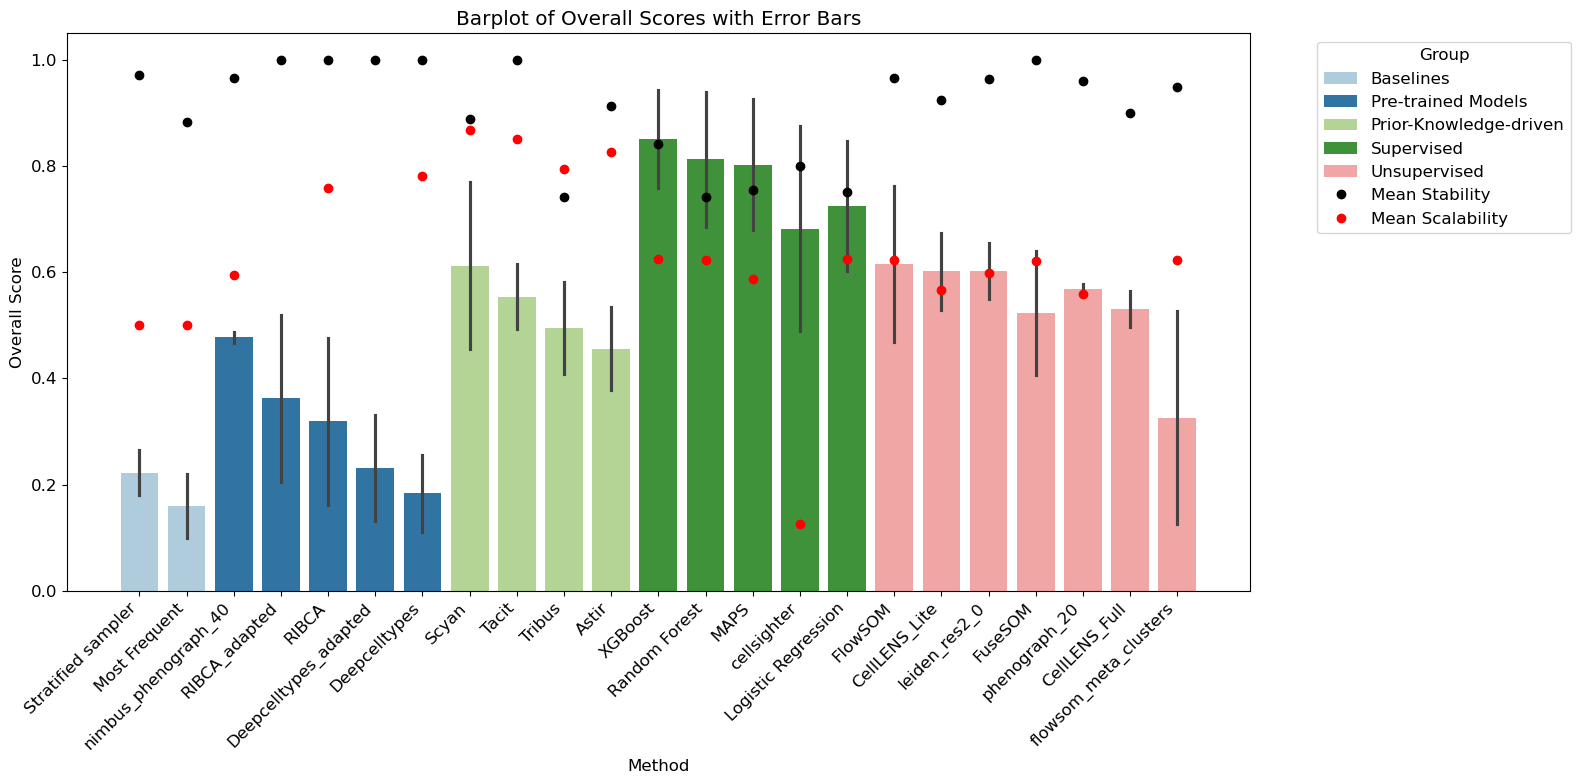

In [68]:
# Sort by scalability (descending)
#df_sorted = df_sorted.sort_values(by="Methodology", ascending=False)

df_sorted = df_sorted.sort_values(by=['Method_group', 'Overall Performance'], ascending=[True, False])  

plt.figure(figsize=(16, 8))
sns.barplot(
    data=df_sorted,
    x="method",
    y="Overall Performance",
    hue="Method_group",
    palette="Paired",
    errorbar="sd",
    order=df_sorted.index.tolist()
)

# calculate mean scalabilty for each method
mean_scalability = df_sorted.groupby("method")["Scalability"].mean().reset_index()
mean_stability = df_sorted.groupby("method")["Stability"].mean().reset_index()


# Add mean stability of each method as dots that are connected by a single line
# Plot mean stability as dots
# Plot mean stability as dots
plt.errorbar(
    x=mean_stability["method"],
    y=mean_stability["Stability"],
    fmt='o',
    color='black',
    label='Mean Stability',
    capsize=5,
)

# Add mean stability of each method as dots that are connected by a single line
plt.errorbar(
    x=mean_stability["method"],
    y=mean_scalability["Scalability"],
    fmt='o',
    color='red',
    label='Mean Scalability',
    capsize=5,
)


# # calculate mean scalabilty for each method
# mean_scalability = df_sorted.groupby("method")["Scalability"].mean().reset_index()
# mean_stability = df_sorted.groupby("method")["Stability"].mean().reset_index()

# # get the unique methods only
# unique_methods = df_sorted.index.unique().tolist()

# #order the mean_scalability and mean_stability by the unique methods
# mean_scalability = mean_scalability[mean_scalability["method"].isin(unique_methods)]
# mean_stability = mean_stability[mean_stability["method"].isin(unique_methods)]  
# # Plot mean scalability as dots and connect them with a line
# plt.plot(mean_scalability.index, mean_scalability["Scalability"], color='red', marker='o', label='Mean Scalability', linewidth=2)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Method')
plt.ylabel('Overall Score')
plt.title('Barplot of Overall Scores with Error Bars')
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## scalability plot

results

In [69]:
results[results['method'] == 'cellsighter'][['train_time_mean', 'inference_time_mean']]

,train_time_mean,inference_time_mean
12,12114.0,6124.681
13,12114.0,6124.681
14,12114.0,6124.681
72,0.0,NaN
73,0.0,NaN
74,0.0,NaN


In [70]:
scalability_plot_lvl3 = results[results["level"] == "level_3"]
scalability_plot_lvl3 = scalability_plot_lvl3[["method", "train_time_mean", "inference_time_mean", "runtime_scaled", "scaling_score", "scalability"]]
scalability_plot_lvl3

,method,train_time_mean,inference_time_mean,runtime_scaled,scaling_score,scalability
2,CellLENS_Lite,0.000,802.312000,0.925712,0.25,0.587856
5,FuseSOM,0.000,81.816000,0.992424,0.25,0.621212
8,Astir,0.000,1021.892000,0.905380,0.75,0.827690
11,CellLENS_Full,0.000,NaN,NaN,0.25,NaN
14,cellsighter,12114.000,6124.681000,0.000000,0.25,0.125000
17,Deepcelltypes,0.000,3041.386000,0.718390,1.00,0.859195
20,Deepcelltypes_adapted,0.000,NaN,NaN,NaN,NaN
23,FlowSOM,0.000,16.612000,0.998462,0.25,0.624231
26,flowsom_meta_clusters,0.000,16.612000,0.998462,0.25,0.624231
29,Logistic Regression,2.040,1.036000,0.999715,0.25,0.624858


In [71]:
# get the mean by method
scalability_plot_lvl3 = scalability_plot_lvl3.groupby("method").mean().reset_index()
scalability_plot_lvl3

,method,train_time_mean,inference_time_mean,runtime_scaled,scaling_score,scalability
0,Astir,0.000,1062.672000,0.901604,0.75,0.825802
1,CellLENS_Full,0.000,NaN,NaN,0.25,NaN
2,CellLENS_Lite,0.000,1250.182000,0.884242,0.25,0.567121
3,Deepcelltypes,0.000,4730.145000,0.562024,1.00,0.781012
4,Deepcelltypes_adapted,0.000,NaN,NaN,NaN,NaN
5,FlowSOM,0.000,22.717000,0.997897,0.25,0.623948
6,FuseSOM,0.000,96.157000,0.991097,0.25,0.620548
7,Logistic Regression,3.410,1.727500,0.999524,0.25,0.624762
8,MAPS,539.095,273.418500,0.924767,0.25,0.587384
9,Most Frequent,0.001,0.000500,1.000000,0.00,0.500000


In [72]:
scalability_plot_lvl3 = scalability_plot_lvl3[~scalability_plot_lvl3['method'].str.contains('adapted', case=False, na=False)]
scalability_plot_lvl3

,method,train_time_mean,inference_time_mean,runtime_scaled,scaling_score,scalability
0,Astir,0.000,1062.672000,0.901604,0.75,0.825802
1,CellLENS_Full,0.000,NaN,NaN,0.25,NaN
2,CellLENS_Lite,0.000,1250.182000,0.884242,0.25,0.567121
3,Deepcelltypes,0.000,4730.145000,0.562024,1.00,0.781012
5,FlowSOM,0.000,22.717000,0.997897,0.25,0.623948
6,FuseSOM,0.000,96.157000,0.991097,0.25,0.620548
7,Logistic Regression,3.410,1.727500,0.999524,0.25,0.624762
8,MAPS,539.095,273.418500,0.924767,0.25,0.587384
9,Most Frequent,0.001,0.000500,1.000000,0.00,0.500000
10,RIBCA,0.000,5206.844333,0.517885,1.00,0.758942


/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_92548/2058308530.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_92548/2058308530.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_92548/2058308530.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

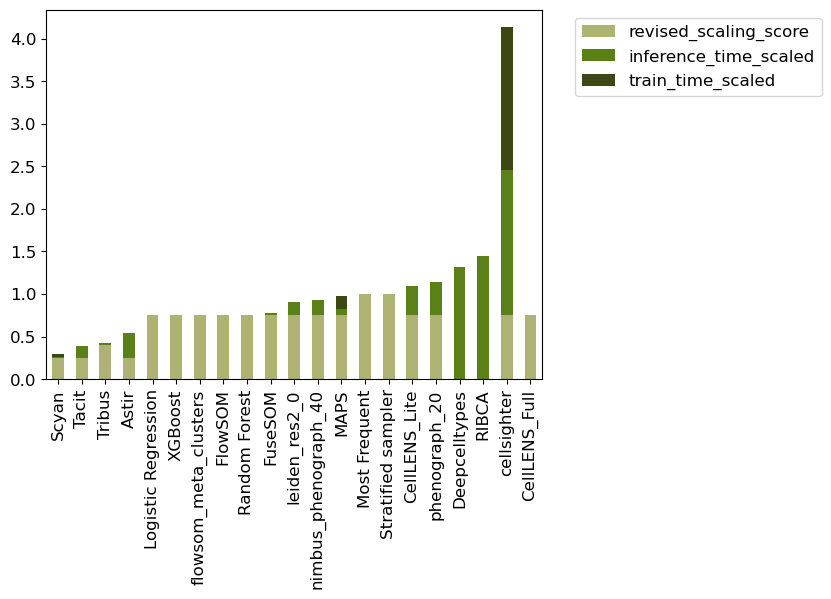

In [79]:
# scale train and inference time to be between 0 and 1 where 0 is fastest and 1 is slowest
inference_thresh = 3600 
train_thresh = 3600

scalability_plot_lvl3["train_time_scaled"] = scalability_plot_lvl3["train_time_mean"] / train_thresh
scalability_plot_lvl3["inference_time_scaled"] = scalability_plot_lvl3["inference_time_mean"] / inference_thresh
scalability_plot_lvl3["revised_scaling_score"] = 1 - scalability_plot_lvl3["scaling_score"]

# Calculate total for ordering
scalability_plot_lvl3["total"] = (
    scalability_plot_lvl3["revised_scaling_score"] +
    scalability_plot_lvl3["inference_time_scaled"] +
    scalability_plot_lvl3["train_time_scaled"]
)

# Sort by total (lowest to highest)
scalability_plot_lvl3_sorted = scalability_plot_lvl3.sort_values("total")

colors = [
    "#aeb374",  # blue
    "#598118",  # orange
    "#3b4814",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b"   # brown
]

colors2 = [
    "#a7e8e2",  # blue
    "#659cb3",  # orange
    "#18605a",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b"   # brown
]

# plot a stacked barplot with methods in the x axis and train and inference time in the y axis
scalability_plot_lvl3_sorted.plot.bar(
    x="method",
    y=["revised_scaling_score", "inference_time_scaled", "train_time_scaled"],
    stacked=True,
    color=colors
)

# move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("")
plt.savefig(os.path.join(output_path, "scalability_plot_lvl3.svg"), format='svg', bbox_inches='tight', dpi=300)


In [75]:
scalability_plot_lvl3

,method,train_time_mean,inference_time_mean,runtime_scaled,scaling_score,scalability,train_time_scaled,inference_time_scaled,revised_scaling_score,total
0,Astir,0.000,1062.672000,0.901604,0.75,0.825802,0.000000e+00,2.951867e-01,0.25,0.545187
1,CellLENS_Full,0.000,NaN,NaN,0.25,NaN,0.000000e+00,NaN,0.75,NaN
2,CellLENS_Lite,0.000,1250.182000,0.884242,0.25,0.567121,0.000000e+00,3.472728e-01,0.75,1.097273
3,Deepcelltypes,0.000,4730.145000,0.562024,1.00,0.781012,0.000000e+00,1.313929e+00,0.00,1.313929
5,FlowSOM,0.000,22.717000,0.997897,0.25,0.623948,0.000000e+00,6.310278e-03,0.75,0.756310
6,FuseSOM,0.000,96.157000,0.991097,0.25,0.620548,0.000000e+00,2.671028e-02,0.75,0.776710
7,Logistic Regression,3.410,1.727500,0.999524,0.25,0.624762,9.472222e-04,4.798611e-04,0.75,0.751427
8,MAPS,539.095,273.418500,0.924767,0.25,0.587384,1.497486e-01,7.594958e-02,0.75,0.975698
9,Most Frequent,0.001,0.000500,1.000000,0.00,0.500000,2.777778e-07,1.388889e-07,1.00,1.000000
10,RIBCA,0.000,5206.844333,0.517885,1.00,0.758942,0.000000e+00,1.446346e+00,0.00,1.446346


In [76]:

methods = scalability_plot_lvl3_sorted["method"].tolist()
revised_scaling_score = scalability_plot_lvl3_sorted["revised_scaling_score"].fillna(0)
inference_time_scaled = scalability_plot_lvl3_sorted["inference_time_scaled"].fillna(0)
train_time_scaled = scalability_plot_lvl3_sorted["train_time_scaled"].fillna(0)

fig = go.Figure(data=[
    go.Bar(name='Revised Scaling Score', x=methods, y=revised_scaling_score, marker_color='#aeb374'),
    go.Bar(name='Inference Time (scaled)', x=methods, y=inference_time_scaled, marker_color='#598118'),
    go.Bar(name='Train Time (scaled)', x=methods, y=train_time_scaled, marker_color='#3b4814')
])


# labels = 14
# Xlabels = 12 
# title = 16
# Legend = 12 
# legend_title = 14

fig.update_layout(
    barmode='stack',
    xaxis_title='Method',
    xaxis_tickangle=-45,
    yaxis_title='Scaled Value',
    title='Scalability Components by Method',
    #legend=dict(x=1.05, y=1, bordercolor="Black", borderwidth=1),
    width=800,
    height=400,
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig.show()

fig.write_html(os.path.join(output_path, "scalability_plot.html"))

# save as svg
#fig.write_image(os.path.join(output_path, "scalability_plot.svg"), width=800, height=400, scale=2)

In [78]:

methods = scalability_plot_lvl3_sorted["method"].tolist()
revised_scaling_score = scalability_plot_lvl3_sorted["revised_scaling_score"].fillna(0)
inference_time_scaled = scalability_plot_lvl3_sorted["inference_time_scaled"].fillna(0)
train_time_scaled = scalability_plot_lvl3_sorted["train_time_scaled"].fillna(0)

fig = go.Figure(data=[
    go.Bar(name='Revised Scaling Score', x=methods, y=revised_scaling_score, marker_color='#aeb374'),
    go.Bar(name='Inference Time (scaled)', x=methods, y=inference_time_scaled, marker_color='#598118'),
    go.Bar(name='Train Time (scaled)', x=methods, y=train_time_scaled, marker_color='#3b4814')
])

fig.update_layout(
    font=dict(
        size=12,           # Default font size for all text
    ),
    xaxis=dict(
        title_font=dict(size=14),   # X-axis title font size
        tickfont=dict(size=12),     # X-axis tick label font size
    ),
    yaxis=dict(
        title_font=dict(size=14),   # Y-axis title font size
        tickfont=dict(size=12),     # Y-axis tick label font size
    ),
    title_font=dict(size=16),       # Title font size
    legend=dict(
        font=dict(size=12),         # Legend font size
        title_font=dict(size=14),   # Legend title font size
    )
)

fig.update_layout(
    barmode='stack',
    xaxis_title='Method',
    xaxis_tickangle=-45,
    yaxis_title='Scaled Value',
    title='Scalability Components by Method',
    #legend=dict(x=1.05, y=1, bordercolor="Black", borderwidth=1),
    width=800,
    height=400,
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig.show()

fig.write_html(os.path.join(output_path, "scalability_plot.html"))

# save as svg
#fig.write_image("../figures/scalability_plot.svg", width=800, height=400, scale=2)